# Funkcje pomocnicze (testujące poprawność algorytmów)

##### Funkcja generująca losowe dane testowe

In [1]:
import random
import math


def non_uniform_randrange(range_, count, k=.2, ints_only=True, round_=2):
    result = []
    limit = k / (math.log(count) or 1 if count else 1)

    while count:
        range_size = range_[1] - range_[0]
        while random.random() > limit and count:
            if ints_only:
                result.append(random.randint(*range_))
            else:
                random_num = round(random.random() * range_size + range_[0], round_)
                result.append(random_num)
            count -= 1

        avg = sum(range_) / 2
        delta = (avg - range_[0]) * k
        range_ = (int(range_[0] + delta - .5), int(range_[1] - delta + .5))

    return result


def generate_test_data(val_counts=(0, 50),       # A minimum and maximum number of values to sort that will be generated
                       range_=(-100, 100),       # A range which will be used to create a random list of values from this range
                       ints_only=True,           # Set this flag to False in order to generate random non-integer numbers
                       round_=2,                 # A number of floating point digits (works only with ints_only set to False
                       uniform_distribution=True # If set to false, non-uniform values will be generated using a function above
                       ):
    if uniform_distribution:
        if ints_only:
            random_lst = [random.randint(*range_) for _ in range(random.randint(*val_counts))]
        else:
            random_lst = []
            range_size = range_[1] - range_[0]
            for _ in range(random.randint(*val_counts)):
                # Shift a random value in order to be in range_ (not lower than the
                # lower bound and not greater than the greater bound)
                random_num = round(random.random() * range_size + range_[0], round_)
                random_lst.append(random_num)
    else:
        random_lst = non_uniform_randrange(range_, random.randint(*val_counts), random.random() / 3, ints_only, round_)

    return random_lst

##### Funkcja testująca poprawność algorytmu

In [2]:
def test_sort(sorting_fn, *, 
              samples=20,                # A number of tests that will be performed
              val_counts=(0, 50),        # A minimum and maximum number of values to sort that will be generated
              range_=(-100, 100),        # A range which will be used to create a random list of values from this range
              uniform_distribution=True, # If set to false, non-uniform values will be generated using a function above
              modifies_arr=True,         # Information whether an algorithm modifies the initial array or returns a sorted array
              failed_only=False,         # Show only failed tests. Works only if no_results is set to False
              print_out_fn=None,         # An user-defined function to print additional information. Works only if no_results is set to False
              no_results=False,          # When set to True, no results will be printed (useful only for benchmark)
              ints_only=True,            # Set this flag to False in order to generate random non-integer numbers
              round_=2                   # A number of floating point digits (works only with ints_only set to False)
             ): 
    passed = 0                   
    for i in range(samples):
        random_lst = generate_test_data(val_counts, range_, ints_only, round_, uniform_distribution)
        random_lst_before = random_lst[:] if modifies_arr else random_lst
        
        # Test if is correct
        expected = sorted(random_lst)
        if not modifies_arr:
            result = sorting_fn(random_lst)
        else:
            sorting_fn(random_lst)
            result = random_lst
        is_correct = result == expected
        passed += is_correct
        
        if not no_results:
            if not failed_only or (failed_only and not is_correct):
                print(f'TEST #{i+1}:')
                print(f'Before sorting: {random_lst_before}')
                print(f'After sorting: {result}')
                print(f'Expected result: {expected}')
                print(f'Test {"PASSED" if is_correct else "FAILED"}')
                print(f'Current passed-to-tested ratio: {passed}/{i+1}')
                if print_out_fn:
                    print(f'========== Additional results after sorting  ==========')
                    print_out_fn(random_lst)
                print()
                
    if not no_results:
        print(f'Sorting algorithm is {"correct" if passed == samples else "wrong"}')
        print(f'Passed tests in total: {passed}/{samples}')

##### Funkcja badająca wydajność algorytmów

In [3]:
import time
from decimal import Decimal
from colorama import Fore, Style

# ATTENTION: This function doesn't check if an algorithm, works properly. In order to test
# your algorithm's correctness, please use a function above
def compare_performance(sorting_functions, *,      # sorting_functions[<fn name>] = (<fn variable>, <globals dict>)
                        samples=100,               # A number of tests that will be performed
                        val_counts=(0, 10_000),    # A minimum and maximum number of values to sort that will be generated
                        range_=(-10_000, 10_000),  # A range which will be used to create a random list of values from this range
                        progress_interval=10,      # A number of tests that will be performed between showing
                                                   # current sorting times (temporary results). When set to 0 no progress will be displayed.
                        uniform_distribution=True, # If set to false, non-uniform values will be generated using a function above
                        ints_only=True             # Set this flag to False in order to generate random non-integer numbers
                       ):                         
    times = dict.fromkeys([fn[0] for fn in sorting_functions], Decimal(0))
    max_fn_name_len = max(len(entry[0]) for entry in sorting_functions)
    inf = float('inf')
    
    for i in range(1, samples + 1):
        random_lst = generate_test_data(val_counts, range_, ints_only, 10, uniform_distribution)
        
        for name, (fn, globals_) in sorting_functions:
            if times[name] == inf: continue
            # Overwrite current global values to make an algorithm able to work (use a proper funciton)
            for obj_name, obj in globals_.items():
                globals()[obj_name] = obj
            # Perform a test
            input_lst = random_lst[:]
            try:
                start_time = time.time()
                fn(input_lst)
                end_time = time.time()
            except RecursionError:
                times[name] = inf
            else:
                times[name] += Decimal(end_time - start_time)
            
        if progress_interval > 0 and not i % progress_interval:
            print(f"===== Results after {i} tests: =====")
            names = sorted(times, key=lambda name: times[name])
            fastest_time = times[names[0]]
            for name in names:
                total_time = times[name]
                if total_time < inf:
                    print(f"{name.ljust(max_fn_name_len)}  Total (in seconds): {total_time:<8.4f}  Average: {total_time/i:<8.4f}", end='')
                    if fastest_time and name != names[0]:
                        ratio = total_time / fastest_time
                        print(f"\t({ratio:.2f}x slower)")
                    else:
                        print()
                else:
                    print(f"{name.ljust(max_fn_name_len)}   {Fore.RED}RECURSION ERROR{Style.RESET_ALL}")
            print()
            
    names = sorted(times, key=lambda name: times[name])
    fastest_time = times[names[0]]
    print("===== Final results: =====")
    print(f"Tests performed: {samples}")
    print("\nTotal times (in seconds):")
    for name in names:
        total_time = times[name]
        if total_time < inf:
            print(f"\t{name.ljust(max_fn_name_len)}:   {total_time:.7f}")
        else:
            print(f"\t{name.ljust(max_fn_name_len)}:   {Fore.RED}RECURSION ERROR{Style.RESET_ALL}")
    print("\nAverage times (in seconds):")
    for name in names:
        total_time = times[name]
        if total_time < inf:
            print(f"\t{name.ljust(max_fn_name_len)}:   {total_time/samples:<8.7f}", end='')
            if fastest_time and name != names[0]:
                ratio = total_time / fastest_time
                print(f"\t({ratio:.2f}x slower)")
            else:
                print()
        else:
            print(f"\t{name.ljust(max_fn_name_len)}:   {Fore.RED}RECURSION ERROR{Style.RESET_ALL}")

##### Słownik służący do zapisania funkcji, w celu porównania wydajności

In [4]:
sorting_functions = {}  # Please store sorting functions using function's name as a string
                        # key and a (function variable, your specified global variables
                        # such as helper functions that re used by a sorting function)
                        # pairs as a value

# Algorytmy o złożoności $ O(n^2) $
### Zazwyczaj wolne, ale łatwe w implementacji i wytłumaczeniu algorytmy. Pozwalają na sortowanie dowolnych danych o dowolnym rozkładzie z dowolnego zakresu.
##### Co ciekawe, algorytmy te są często szybsze od algorytmów szybkiego sortowania, jeżeli do posortowania mamy mały zbiór danych (kilkanaście elementów).

## Bubble Sort

### Złożoność sortowania

#### Złożoność czasowa

###### Najgorszy przypadek
##### $ O(n^2) $

###### Najlepszy przypadek
##### $ O(n^2) $

#### Złożoność pamięciowa

###### Najgorszy przypadek
##### $ O(1) $

###### Najlepszy przypadek
##### $ O(1) $

### Stabilność

###### Stabilny

Ponieważ wykonujemy zamiany sąsiednych wartości tylko wtedy, gdy jedna jest większa od drugiej. Kolejność żadnych dwóch elementów o tych samych kluczach, według których sortujemy daną sekwencję, nie zostanie zmieniona, ponieważ zamieniamy tylko te elementy, których klucze są różne, a klucz tego, który znajduje się wcześniej, jest większy od klucza tego, który znajduje się później (przy sortowaniu w kolejności malejącej, postępujemy odwrotnie)

### Czy sortowanie odbywa się w miejscu?*

##### * Powiemy, że sortowanie odbywa się w miejscu, jeżeli podczas procesu sortowania jest wykorzystywana stała ilość pamięci, niezależna od wielkości sortowanej struktury (tzn. elementy nie są tymczasowo przepisywane do struktur pomocniczych). Zazwyczaj** sortowanie w miejscu można odróżnić po tym, że po procesie sortowania zmodyfikowana zostaje sortowana struktura, a w przypadku sortowania, które nie sortuje w miejscu, zwrócona jest nowa struktura (tej samej wielkości, co wejściowa), zawierająca posortowane dane, a wejściowa struktura pozostaje nienaruszona.

##### ** Zazwyczaj, ponieważ możemy napisać funkcję, która "przepisze" posortowane dane z używanej tymczasowo struktury do sortowanej struktury, więc wejściowa struktura zostanie zmodyfikowana (patrz implementacja Merge Sort #2).

###### Tak

### Implementacja algorytmu

In [5]:
def bubble_sort(arr):
    for i in range(len(arr)-1):      
        for j in range(len(arr)-1-i):
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [6]:
sorting_functions['Bubble Sort'] = (bubble_sort, {})

Kilka testów

In [7]:
test_sort(bubble_sort, samples=100, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


## Selection Sort

### Złożoność sortowania

#### Złożoność czasowa

###### Najgorszy przypadek
##### $ O(n^2) $

###### Najlepszy przypadek
##### $ O(n^2) $

#### Złożoność pamięciowa

###### Najgorszy przypadek
##### $ O(1) $

###### Najlepszy przypadek
##### $ O(1) $

### Stabilność

###### Niestabilny

Wynika to stąd, że w każdym przebiegu wewnętrznej pętli, poszukujemy elementu, którgo klucz jest w danym momencie najmniejszy (największy - przy sortowaniu w kolejności nierosnącej) spośród kluczy elementów, znajdujących się w sprawdzanej w drugiej pętli elementów. Ponieważ sprawdzamy tylko te elementy sekwencji, które znajdują się dalej od elementu, na którym w danym momencie "zatrzymała" się zewnętrzna pętla oraz poszukujemy elementu najmniejszego spośród sprawdzanych, istnieje możliwość, że wskutek zamiany elementu najmniejszego z elementem z zewnętrznej pętli, element z zewnętrznej pętli znajdzie się dalej niż inny element, który posiada ten sam klucz. Wynika stąd, że wzajemna odległość elementów, które posiadają te same klucze, może zostać (i zazwyczaj jest) zmieniona.

Przykład:
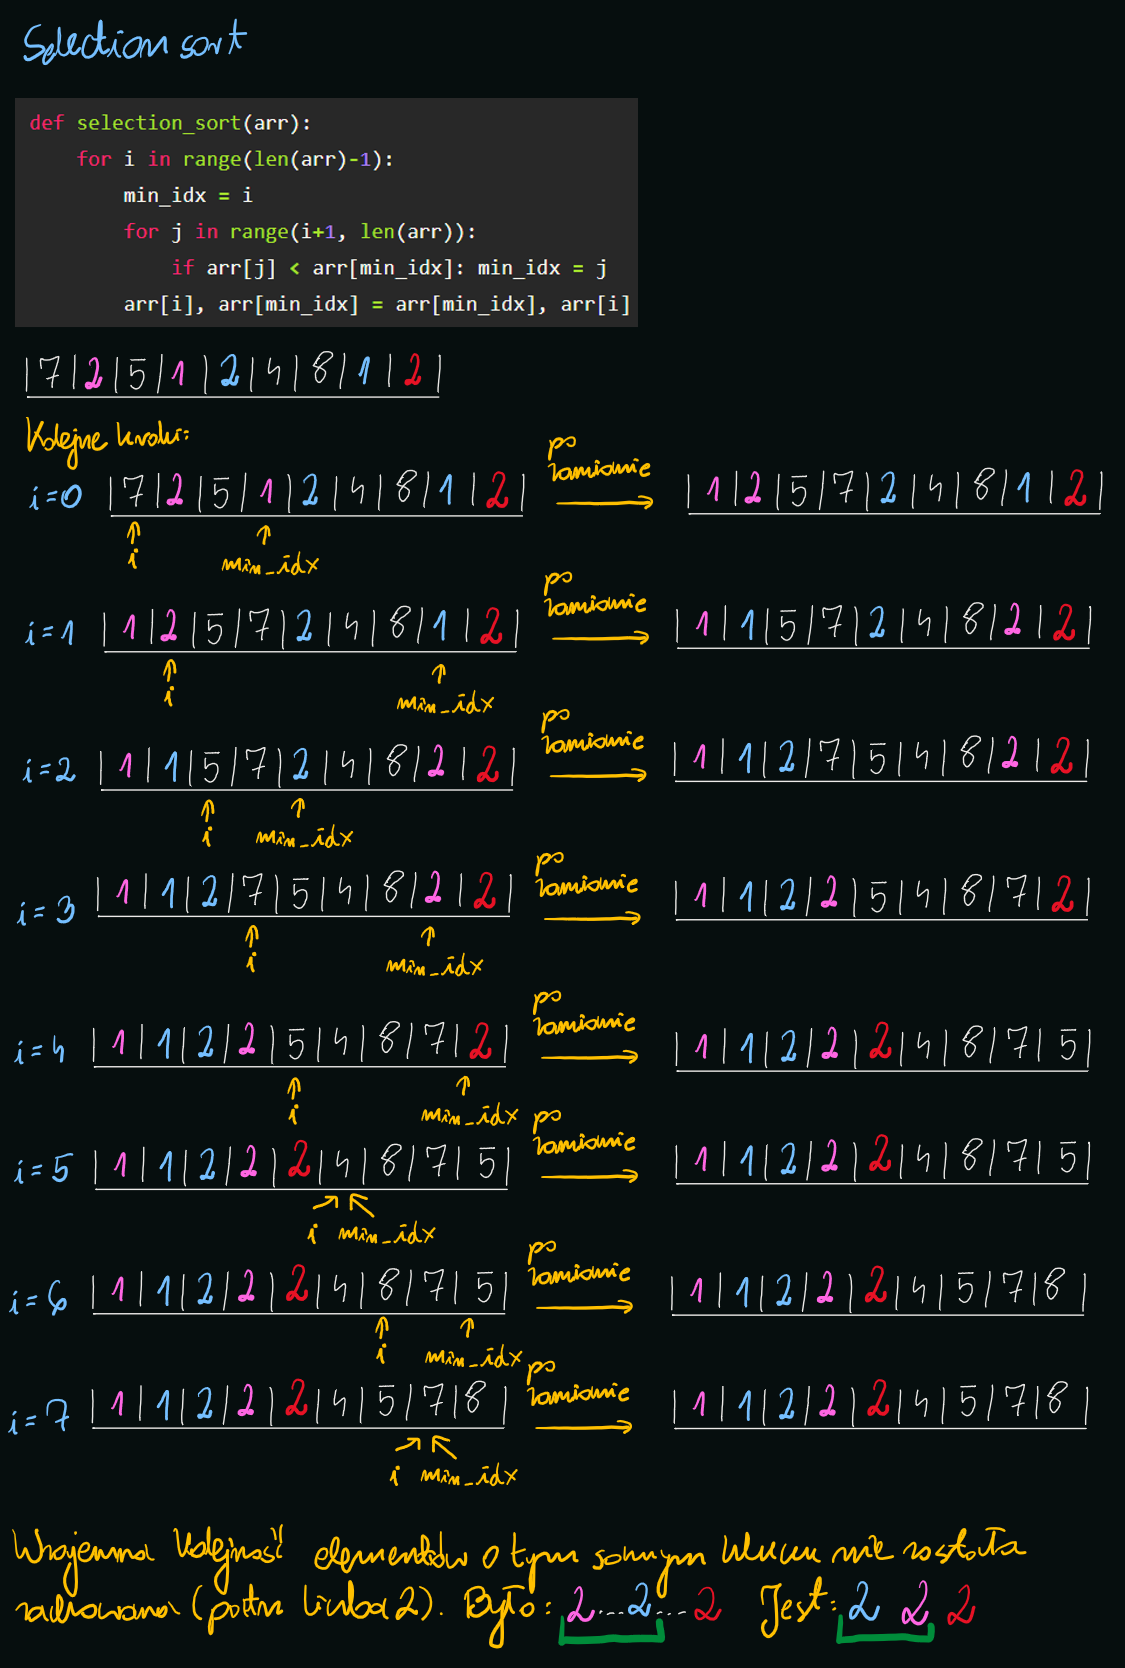

### Czy sortowanie odbywa się w miejscu?

###### Tak

### Implementacja algorytmu

In [8]:
def selection_sort(arr):
    for i in range(len(arr)-1):
        min_idx = i
        for j in range(i+1, len(arr)):
            if arr[j] < arr[min_idx]: min_idx = j
        arr[i], arr[min_idx] = arr[min_idx], arr[i]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [9]:
sorting_functions['Selection Sort'] = (selection_sort, {})

Kilka testów

In [10]:
test_sort(selection_sort, samples=100, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


## Insertion Sort

### Złożoność sortowania

#### Złożoność czasowa

###### Najgorszy przypadek
##### $ O(n^2) $

###### Najlepszy przypadek
##### $ O(n) $

#### Złożoność pamięciowa

###### Najgorszy przypadek
##### $ O(1) $

###### Najlepszy przypadek
##### $ O(1) $

### Stabilność

###### Stabilny

Wynika to stąd, że dany element, który jest mniejszy od poprzedniego (przy sortowaniu w kolejności malejącej - większy od poprzedniego) przesuwamy w lewo, dopóki jest on mniejszy (większy) od elementu, który go w danym momencie poprzedza. Dlatego, jeżeli zdarzy się kilka elementów, które mają ten sam klucz, według którego przeprowadzamy sortowanie, przesuwany element wstawiony zostanie za ostatnim elementem, którego klucz jest taki sam jak klucz elementu, który przemieszczamy, więc nie istnieje możliwość wzajemnej zmiany kolejności elementów, które posiadają ten sam klucz.

### Czy sortowanie odbywa się w miejscu?

###### Tak

### Implementacja algorytmu

In [11]:
def insertion_sort(arr):
    for i in range(1, len(arr)):
        j = i-1
        temp = arr[i]
        
        while j >= 0 and temp < arr[j]:
            arr[j+1] = arr[j]
            j -= 1
        
        arr[j+1] = temp

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [12]:
sorting_functions['Insertion Sort'] = (insertion_sort, {})

Kilka testów

In [13]:
test_sort(insertion_sort, samples=100, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


# Algorytmy o złożoności $ O(n \cdot log(n)) $
### Najszybsze uniwersalne (do sortowania danych dowolnego typu o dowolnym rozkładzie z dowolnego zakresu).

## Merge Sort

### Złożoność sortowania

#### Złożoność czasowa

###### Najgorszy przypadek
##### $ O(n \cdot log(n)) $

###### Najlepszy przypadek
##### $ O(n \cdot log(n)) $

#### Złożoność pamięciowa

###### Najgorszy przypadek
##### $ O(n) $

###### Najlepszy przypadek
##### $ O(n) $

### Stabilność

###### Stabilny

Ponieważ zawsze iterujemy przez elementy tablicy (lub jej fragmentów) w kolejności od lewej strony do prawej, a zamiana kolejności elementów występuje wyłącznie podczas łączenia dwóch fragmentów tablic w jedną posortowaną (funkcja $ merge $) i polega na tym, że najpierw do tablicy wynikowej przepisujemy ten element z jednej z tablic, który jest nie większy niż ten z drugiej z tablic, nie istnieje możliwość wzajemnej zamiany kolejności elementów o tych samych kluczach (jeżeli oba porównywane elementy z obu tablic mają taki sam klucz, w funkcji złączającej dwie tablice zawsze podjęta zostanie ta sama decyzja, dotycząca wyboru pierwszego przepisanego elementu, np. pierwszy będzie ten z pierwszej z tablic, a ponieważ zawsze będzie obowiązywała taka sama zasada, nie ma możliwości zamiany kolejności tych elementów względem początkowej).

### Czy sortowanie odbywa się w miejscu?

###### Nie

### Implementacja algorytmu #1 
#### (zwraca nową sekwencję) (NAJGORSZA implementacja - tworzy kopie fragmentów tablicy)

In [14]:
def merge_sort(arr):
    if len(arr) <= 1: return arr

    mid_idx = len(arr) // 2
    # Sort recursively a left and a right part of an array
    left = merge_sort(arr[:mid_idx])
    right = merge_sort(arr[mid_idx:])

    # Return a merged array
    return _merged(left, right)


def _merged(left, right):
    result = []
    left_idx = right_idx = 0

    # Rewrite values in a right (non-descending) order
    while left_idx < len(left) and right_idx < len(right):
        if left[left_idx] < right[right_idx]:
            result.append(left[left_idx])
            left_idx += 1
        else:
            result.append(right[right_idx])
            right_idx += 1

    # Rewrite remaining values if there are some in one of the parts
    for i in range(left_idx, len(left)):
        result.append(left[i])

    for i in range(right_idx, len(right)):
        result.append(right[i])

    return result

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [15]:
sorting_functions['Merge Sort (#1)'] = (merge_sort, {
    '_merged': _merged
})

Kilka testów

In [16]:
test_sort(merge_sort, samples=100, modifies_arr=False, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #2 
#### (modyfikuje sortowaną sekwencję) (o dziwo nawet wolniejsza implementacja niż powyższa - przekazuje indeksy a nie tablice)

In [17]:
def merge_sort(arr):
    # _sort takes left_idx inclusive and right_idx exclusive
    # (same as Python's range function does)
    def _sort(left_idx, right_idx):
        # If there are less than 2 elements in a part, do nothing
        if right_idx - left_idx < 2: return
                
        mid_idx = (left_idx + right_idx) // 2
        _sort(left_idx, mid_idx)
        _sort(mid_idx, right_idx)
        merge(left_idx, mid_idx, right_idx)
    
    def merge(i, j, right_end):
        left_begin = i
        left_end = j
        merged = []
        
        while i < left_end and j < right_end:
            if arr[i] < arr[j]:
                merged.append(arr[i])
                i += 1
            else:
                merged.append(arr[j])
                j += 1
        
        for i in range(i, left_end):
            merged.append(arr[i])
            
        for j in range(j, right_end):
            merged.append(arr[j])
            
        idx = left_begin
        for val in merged:
            arr[idx] = val
            idx += 1
            
    _sort(0, len(arr))

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [18]:
sorting_functions['Merge Sort (#2)'] = (merge_sort, {})

Kilka testów

In [19]:
test_sort(merge_sort, samples=100, modifies_arr=True, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #3 
#### (zwraca nową sekwencję) (najlepsza implementacja - nie trzeba alokować co chwilę nowych tablic oraz niepotrzebnie kilka razy przepisywać wartości) (wersja bez rekurencji)

In [20]:
def merge_sort(arr):
    temp_arr = [None] * len(arr)
    step = 1

    while step < len(arr):
        for left_idx in range(0, len(arr)-step, 2 * step):
            mid_idx = left_idx + step
            right_idx = mid_idx + step

            if right_idx > len(arr): right_idx = len(arr)

            # Perform merging
            i = left_idx
            j = mid_idx
            k = left_idx

            while i < mid_idx and j < right_idx:
                if arr[i] <= arr[j]:
                    temp_arr[k] = arr[i]
                    i += 1
                else:
                    temp_arr[k] = arr[j]
                    j += 1
                k += 1

            # Rewrite the remaining values
            for i in range(i, mid_idx):
                temp_arr[k] = arr[i]
                k += 1

            for j in range(j, right_idx):
                temp_arr[k] = arr[j]
                k += 1

        # If there are still some values remaining, rewrite them
        for k in range(k, len(arr)):
            temp_arr[k] = arr[k]

        # Swap arrays
        arr, temp_arr = temp_arr, arr
        step *= 2

    return arr

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [21]:
sorting_functions['Merge Sort (#3)'] = (merge_sort, {})

Kilka testów

In [22]:
test_sort(merge_sort, samples=100, modifies_arr=False, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


## Heap Sort

Heap Sort polega na zbudowaniu KOMPLETNEGO drzewa binarnego z kolejnych wartości, jakie znajdują się w sortowanej sekwencji (tablicy), a dokładniej struktury, która nazywa się Max Heap, a następnie odczycie kolejnych największych wartości z pozostałej części struktury i przenoszeniu wartości już posortowanych na koniec sekwencji (tablicy). Budowa struktury jest szybka, a jej złożoność czasowa wynosi $ O(n) $, natomiast sam odczyt wartości z "Maksymalnego Kopca" (Max Heap) wymaga już wykonania $ O(n \cdot log(n)) $ operacji. Wynika to stąd, że za każdym razem ściągamy wartość z korzenia kopca (kompletnego drzewa binarnego), tym samym "psując" kopiec. W miejsce usuniętej wartości wstawiamy dowolną wartość (najlepiej ostatni z liści), a następnie naprawiamy drzewo w czasie $ O(log(n)) $.

Dokładniejsze wyjaśnienie sposobu działania algorytmu oraz funkcjonowania samej struktury, jaką jest Heap, znajduje się poniżej:
###### Binary Heap: https://www.youtube.com/watch?v=g9YK6sftDi0
###### Heap Sort:  https://www.youtube.com/watch?v=k72DtCnY4MU

Warto jeszcze nadmienić, że Binary Heap nie wymaga tworzenia drzewa binarnego, ani korzystania z jakichkolwiek pomocniczych struktur. Wszystkie operacje można przeprowadzić bezpośrednio na tablicy, jedynie korzystając z tablicy jako odpowiedniej reprezentacji wartości zapisanych w "kopcu". Mimo to, Heap Sort zaliczany jest do najwolniejszych algorytmów sortowania (jest najwolniejszy z omawianych algorytmów o złożoności $ O(n \cdot log(n)) $ - patrz testy na końcu pliku)

Grafika z Cormena:
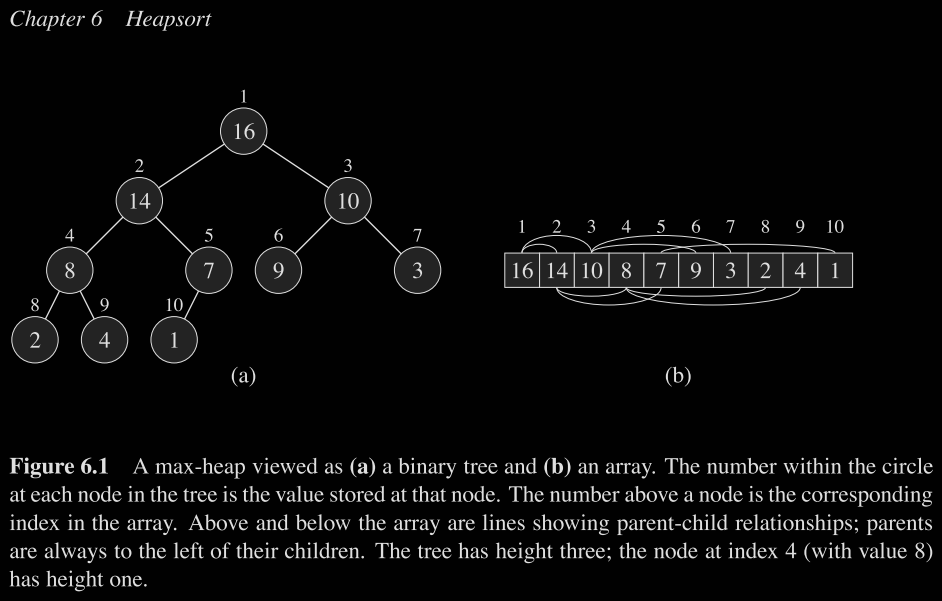

### Złożoność sortowania

#### Złożoność czasowa

###### Najgorszy przypadek
##### $ O(n \cdot log(n)) $

###### Najlepszy przypadek
##### $ O(n \cdot log(n)) $

#### Złożoność pamięciowa

###### Najgorszy przypadek
##### $ O(1) $

###### Najlepszy przypadek
##### $ O(1) $

### Stabilność

###### Niestabilny

### Czy sortowanie odbywa się w miejscu?

###### Tak

### Implementacja algorytmu #1 
#### (z użyciem klasy do reprezentacji struktury Max Heap)

In [23]:
class MaxHeap:
    def __init__(self, values=None):
        self.heap = values  # We don't make a copy of these values
        self.build_heap()
        
    @property
    def heap_size(self):
        return len(self.heap)
    
    @staticmethod
    def left_child_idx(curr_idx):
        return curr_idx * 2 + 1
    
    @staticmethod
    def right_child_idx(curr_idx):
        return curr_idx * 2 + 2
    
    def swap(self, i, j):
        self.heap[i], self.heap[j] = self.heap[j], self.heap[i]
        
    def max_heapify(self, curr_idx, end_idx):  # O(log n)
        # Loop till the current node has a child larger than itself
        # We assume that when we enter a node which both children are
        # smaller than this node, a subtree which a current node is a
        # root of must fulfill a max-heap property.
        while True:
            l = self.left_child_idx(curr_idx)
            r = self.right_child_idx(curr_idx)
            largest_idx = curr_idx

            if l < end_idx:
                if self.heap[l] > self.heap[curr_idx]: 
                    largest_idx = l
                if r < end_idx and self.heap[r] > self.heap[largest_idx]:
                    largest_idx = r

            if largest_idx != curr_idx:
                self.swap(curr_idx, largest_idx)
                curr_idx = largest_idx
            else:
                break
        
    def build_heap(self):  # O (n)
        for i in range((self.heap_size - 1) // 2, -1, -1):
            self.max_heapify(i, self.heap_size)
            
            
def heap_sort(arr):
    max_heap = MaxHeap(arr)
    # Swap the currently greatest value (a heap's root) with a value
    # stored at index i in an array representing a heap and fix
    # a heap after doing such a change.
    for i in range(len(arr)-1, 0, -1):
        arr[0], arr[i] = arr[i], arr[0]
        # Fix a heap
        max_heap.max_heapify(0, i)

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [24]:
sorting_functions['Heap Sort (#1)'] = (heap_sort, {'MaxHeap': MaxHeap})

##### Funkcja do wizualizacji drzew (tu: struktury Max Heap)

In [25]:
def print_heap(values):
    if values:
        just = 0
        data = []

        limit = 1
        values_row = []
        branches_row = []
        prev_nodes = 0

        for i in range(1, len(values) + 1):
            curr_nodes = i - prev_nodes
            val_str = str(values[i-1])
            just = max(just, len(val_str))
            values_row.append(val_str)
            right_child_idx = 2 * i
            left_child_idx = right_child_idx - 1
            if left_child_idx < len(values):
                branches_row.append('/')
            if right_child_idx < len(values):
                branches_row.append('\\')

            if curr_nodes == limit: 
                prev_nodes = i
                limit *= 2
                data.append([values_row, branches_row])
                values_row = []
                branches_row = []

        if values_row:
            data.append([values_row, branches_row])

        begin_sep = sep = 3 if just % 2 else 2
        data_iter = iter(data[::-1])
        result = [''] * (len(data) * 2 - 1)
        result[-1] = (' ' * sep).join(val.center(just) for val in next(data_iter)[0])

        # Format the tree string
        for i, (values, branches) in enumerate(data_iter):
            mul = 2 * i + 1
            # Values
            indent = (2 ** (i + 1) - 1) * (just + begin_sep) // 2
            sep = 2 * sep + just
            result[-(mul + 2)] = f"{' ' * indent}{(' ' * sep).join(val.center(just) for val in values)}"
            # Branches
            branch_indent = (3 * indent + just) // 4
            branches_row = []
            d_indent = indent - branch_indent
            branches_sep = ' ' * (2 * (d_indent - 1) + just)
            for i in range(0, len(branches), 2):
                branches_row.append(f"{branches[i]}{branches_sep}{branches[i + 1] if i + 1 < len(branches) else ''}")
            result[-(mul + 1)] = f"{' ' * branch_indent}{(' ' * (sep - 2 * d_indent)).join(branches_row)}"

        print('\n'.join(result))
    else:
        print('')

Kilka testów

In [26]:
test_sort(heap_sort, samples=3, val_counts=(0, 31), print_out_fn=print_heap, ints_only=False, round_=1)

TEST #1:
Before sorting: [-80.6, -72.5, -32.8, 53.5]
After sorting: [-80.6, -72.5, -32.8, 53.5]
Expected result: [-80.6, -72.5, -32.8, 53.5]
Test PASSED
Current passed-to-tested ratio: 1/1
========== Additional results after sorting  ==========
            -80.6
          /       \
    -72.5           -32.8
    /   
 53.5

TEST #2:
Before sorting: [-62.0, 97.4, 0.8, 70.1, -63.3, -94.7, 98.6, -22.1, 90.8]
After sorting: [-94.7, -63.3, -62.0, -22.1, 0.8, 70.1, 90.8, 97.4, 98.6]
Expected result: [-94.7, -63.3, -62.0, -22.1, 0.8, 70.1, 90.8, 97.4, 98.6]
Test PASSED
Current passed-to-tested ratio: 2/2
========== Additional results after sorting  ==========
                            -94.7
                      /               \
            -63.3                           -62.0
          /       \                       /       \
    -22.1            0.8             70.1            90.8
    /   \
 97.4    98.6

TEST #3:
Before sorting: [53.0, 10.9, 38.5, 23.4, 85.8, 94.3, -14.1, -55.0, 34.7,

### Implementacja algorytmu #2
#### (jedynie z użyciem funkcji)

In [27]:
_left = lambda i: 2 * i + 1
_right = lambda i: 2 * i + 2


def max_heapify(arr, curr_idx, end_idx):
    # Loop till the current node has a child larger than itself
    # We assume that when we enter a node which both children are
    # smaller than this node, a subtree which a current node is a
    # root of must fulfill a max-heap property.
    while True:
        i = _left(curr_idx)
        j = _right(curr_idx)
        k = curr_idx
        
        if i < end_idx:
            if arr[i] > arr[k]:
                k = i
            if j < end_idx and arr[j] > arr[k]:
                k = j
                
        if k == curr_idx: return
        # Swap the current with the largest child
        arr[curr_idx], arr[k] = arr[k], arr[curr_idx]
        curr_idx = k

        
def build_heap(arr):
    for i in range((len(arr) - 1) // 2, -1, -1):
        max_heapify(arr, i, len(arr))

        
def heap_sort(arr):
    build_heap(arr)
    # Swap the currently greatest value (a heap's root) with a value
    # stored on index i in an array representing a heap and fix
    # a heap after doing such a change.
    for i in range(len(arr)-1, 0, -1):
        arr[0], arr[i] = arr[i], arr[0]
        # Fix a heap
        max_heapify(arr, 0, i)

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [28]:
sorting_functions['Heap Sort (#2)'] = (heap_sort, {
    'max_heapify': max_heapify,
    'build_heap': build_heap,
    '_left': _left,
    '_right': _right
})

Kilka testów

In [29]:
test_sort(heap_sort, samples=3, val_counts=[0, 31], print_out_fn=print_heap, ints_only=False, round_=2)

TEST #1:
Before sorting: [58.62, -89.78, -46.01, 62.38, -7.21, -82.29, 89.96, 33.51, 93.59, 97.62, -50.54, 47.86, 20.83, 24.92, -5.11, -69.63, 16.39, 70.56, 51.63, -53.97, 33.76]
After sorting: [-89.78, -82.29, -69.63, -53.97, -50.54, -46.01, -7.21, -5.11, 16.39, 20.83, 24.92, 33.51, 33.76, 47.86, 51.63, 58.62, 62.38, 70.56, 89.96, 93.59, 97.62]
Expected result: [-89.78, -82.29, -69.63, -53.97, -50.54, -46.01, -7.21, -5.11, 16.39, 20.83, 24.92, 33.51, 33.76, 47.86, 51.63, 58.62, 62.38, 70.56, 89.96, 93.59, 97.62]
Test PASSED
Current passed-to-tested ratio: 1/1
========== Additional results after sorting  ==========
                                                            -89.78
                                              /                                \
                            -82.29                                                          -69.63
                      /                \                                              /                \
            -53.97       

## Quick Sort

### Złożoność sortowania

#### Złożoność czasowa

###### Najgorszy przypadek
##### $ O(n^2) $
##### lub: $ O(n \cdot log(n)) $ przy skorzystaniu z wyboru pivota przy pomocy algorytmu Mediana Median (zwanego dla $ k = 5 $, gdzie $ k $ - liczebność grup, na które dzielimy tablicę, "Magiczne Piątki")
###### UWAGA: W tym przypadku można zauważyć, że fakt iż algorytm z użyciem Magicznych Piątek ma niższą najgorszą złożoność czasową i taką zamą złożoność oczekiwaną, nie świadczy wcale o jego szybszym działaniu. W większości przypadków, gdy otrzymujemy dane, które nie są posortowane, zauważymy spadek wydajności, ponieważ zawsze konieczne jest wyznaczenie dodatkowo mediany median, która w danym przypadku nic nie poprawia.

###### Najlepszy przypadek
##### $ O(n \cdot log(n)) $

#### Złożoność pamięciowa

###### Najgorszy przypadek
##### $ O(n) $
Jedynie dla niezoptymalizowanych pod kątem pamięci implementacji (są to 3 pierwsze implementacje niżej, kolejne już tylko wymagają $ O(log(n)) $ pamięci)

###### Najlepszy przypadek
##### O(log(n))
Zazwyczaj ten algorytm sortowania ma taką złożoność pamięciową. Można go zaimplementować w taki sposób, że $ O(lon(n)) $ jest jednocześnie jego średnią oraz najgorszą złożonością pamięciową (patrz implementacja #4 i kolejne)

### Stabilność

###### Niestabilny

### Czy sortowanie odbywa się w miejscu?

###### Tak (przy założeniu, że pamięć, jaką zajmuje stos rekurencyjny, wliczamy do złożoności)
Głosy są podzielone. Niby nie rezerwujemy pamięci w sposób jawny w celu tymczasowego przechowywania częściowo posortowanych danych, ale jednak złożoność pamięciowa algorytmu nie wynosi $ O(1) $, ponieważ zmienne przechowywane na stosie rekurencyjnym również zajmują pamięć, więc stwierdzenie, czy sortowanie odbywa się w miejscu, zależy od tego, jak na to spojrzymy.

### Implementacja algorytmu #1
#### (Wersja rekurencyjna ze sztywno ustalonym pivotem - my wybieramy ostatni element tablicy - z wykorzystaniem algorytmu podziału zaproponowanego przez Lomuto)

In [30]:
def quick_sort(arr):
    _quick_sort(arr, 0, len(arr) - 1)
    

def _quick_sort(arr, left_idx, right_idx):
    while left_idx < right_idx:
        pivot_position = partition(arr, left_idx, right_idx)
        _quick_sort(arr, left_idx, pivot_position - 1)
        left_idx = pivot_position + 1  # I removed a tailing recursion
        
''' Bez usuwania rekursji ogonowej, algorytm wygląda następująco: '''
#     if left_idx < right_idx:
#         pivot_position = partition(arr, left_idx, right_idx)
#         _quick_sort(arr, left_idx, pivot_position - 1)
#         _quick_sort(arr, pivot_position + 1, right_idx)
        
        
def partition(arr, left_idx, right_idx):
    pivot = arr[right_idx]
    
    # Partition an array into 2 subarrays of elements lower than
    # pivot and of elements greater than a pivot
    i = left_idx
    for j in range(left_idx, right_idx):
        if arr[j] < pivot:
            swap(arr, i, j)
            i += 1
    
    # Place a pivot element on its destination index
    swap(arr, i, right_idx)
    
    return i  # Return a pivot position after the last swap
    
    
def swap(arr, i, j):
    arr[i], arr[j] = arr[j], arr[i]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [31]:
sorting_functions['Quick Sort (#1 - Lomuto parition)'] = (quick_sort, {
    '_quick_sort': _quick_sort,
    'partition': partition,
    'swap': swap
})

Kilka testów

In [32]:
test_sort(quick_sort, samples=100, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #2
#### (Wersja rekurencyjna ze sztywno ustalonym pivotem - korzysta z algorytmu Hoare’a podziału tablicy)

###### UWAGA:

O ile w implementacji funkcji partition zaproponowanej przez Lomuto mamy pewność, że po podziale, pivot znajduje się na swojej końcowej pozycji, tj. wyznaczyliśmy jego położenie końcowe w posortowanej tablicy, więc w kolejnych iteracjach sortujemy pozostałe części tablicy z pominięciem pivota, tak w implementacji funkcji podziału Hoare'a, wiemy jedynie, że pivot znajduje się pod koniec na zwróconej przez funkcję partition pozycji i należy do części tablicy, składającej się z elementów od niego mniejszych i mu równych. Nie oznacza to, że pivot znalazł się na swojej końcowej pozycji, więc musimy posortować lewą część tablicy wraz z pivotem oraz prawą (bez pivota).

In [33]:
def quick_sort(arr):
    _quick_sort(arr, 0, len(arr) - 1)
    

def _quick_sort(arr, left_idx, right_idx):
    while left_idx < right_idx:
        pivot_position = partition(arr, left_idx, right_idx)
        _quick_sort(arr, left_idx, pivot_position),  '<- zamiast pivot_position + 1 jest samo pivot_position'
        left_idx = pivot_position + 1  # I removed a tailing recursion
        
''' Funkcja partition jest zmieniona: '''     
def partition(arr, left_idx, right_idx):
    pivot = arr[left_idx]
    
    # Partition an array into 2 subarrays of elements lower than or
    # equal to a pivot and of elements greater or equal to a pivot 
    # (in this partition algorithm pivot isn't placed on a fixed position 
    # but can be also swapped like all the remaining values)
    i = left_idx - 1
    j = right_idx + 1
    while True:
        i += 1
        while arr[i] < pivot: i += 1
            
        j -= 1
        while arr[j] > pivot: j -= 1
        
        if i < j:
            swap(arr, i, j)
        else:
            return j  # Return a pivot position after the last swap
''' Koniec funkcji partition ''' 
    
def swap(arr, i, j):
    arr[i], arr[j] = arr[j], arr[i]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [34]:
sorting_functions['Quick Sort (#2 - Hoare\'s partition)'] = (quick_sort, {
    '_quick_sort': _quick_sort,
    'partition': partition,
    'swap': swap
})

Kilka testów

In [35]:
test_sort(quick_sort, samples=100, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #3
#### (Wersja rekurencyjna z losowo wybieranym pivotem - korzystamy z funkcji partition Hoare'a, ponieważ jest nieco szybsza od wersji Lomuto (nie wykonuje niepotrzebnych zamian elementów))

In [36]:
import random


def quick_sort(arr):
    _quick_sort(arr, 0, len(arr) - 1)
    

def _quick_sort(arr, left_idx, right_idx):
    while left_idx < right_idx:
        pivot_position = partition(arr, left_idx, right_idx)
        _quick_sort(arr, left_idx, pivot_position)
        left_idx = pivot_position + 1  # I removed a tailing recursion
        
        
def partition(arr, left_idx, right_idx):
    pivot = arr[random.randint(left_idx, right_idx)]
    
    # Partition an array into 2 subarrays of elements lower than or
    # equal to a pivot and of elements greater or equal to a pivot 
    # (in this partition algorithm pivot isn't placed on a fixed position 
    # but can be also swapped like all the remaining values)
    i = left_idx - 1
    j = right_idx + 1
    while True:
        i += 1
        while arr[i] < pivot: i += 1
            
        j -= 1
        while arr[j] > pivot: j -= 1
        
        if i < j:
            swap(arr, i, j)
        else:
            return j  # Return a pivot position after the last swap

    
def swap(arr, i, j):
    arr[i], arr[j] = arr[j], arr[i]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [37]:
sorting_functions['Quick Sort (#3 - random pivot)'] = (quick_sort, {
    '_quick_sort': _quick_sort,
    'partition': partition,
    'swap': swap
})

In [38]:
test_sort(quick_sort, samples=100, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #4
#### (Wersja rekurencyjna z losowo wybieranym pivotem, która zajmuje tylko $ O(log n) $ dodatkowej pamięci - na wywołania rekurencyjne)

In [39]:
import random


def quick_sort(arr):
    _quick_sort(arr, 0, len(arr) - 1)
    

def _quick_sort(arr, left_idx, right_idx):
    while left_idx < right_idx:
        pivot_position = _partition(arr, left_idx, right_idx)
        
        ''' Zmiany poniżej: '''
        if pivot_position - left_idx < right_idx - pivot_position:
            _quick_sort(arr, left_idx, pivot_position)
            left_idx = pivot_position + 1  # I removed a tailing recursion
        else:
            _quick_sort(arr, pivot_position + 1, right_idx)
            right_idx = pivot_position  # I removed a tailing recursion
        ''' Koniec zmian '''
        
        
def _partition(arr, left_idx, right_idx):
    pivot = arr[random.randint(left_idx, right_idx)]
    # Partition an array into 2 subarrays of elements lower than or
    # equal to a pivot and of elements greater or equal to a pivot 
    # (in this partition algorithm pivot isn't placed on a fixed position 
    # but can be also swapped like all the remaining values)
    i = left_idx - 1
    j = right_idx + 1
    while True:
        i += 1
        while arr[i] < pivot: i += 1
            
        j -= 1
        while arr[j] > pivot: j -= 1
        
        if i < j:
            _swap(arr, i, j)
        else:
            return j  # Return a pivot position after the last swap

    
def _swap(arr, i, j):
    arr[i], arr[j] = arr[j], arr[i]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [40]:
sorting_functions['Quick Sort (#4 - O(log n) memory)'] = (quick_sort, {
    '_quick_sort': _quick_sort,
    '_partition': _partition,
    '_swap': _swap
})

Kilka testów

In [41]:
test_sort(quick_sort, samples=100, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #5
#### (Wersja iteracyjna z użyciem stosu o stałym rozmiarze (jako stos używamy tabicę o długości $ log_2(n) $). Jest to zoptymalizowana pamięciowo i wydajnościowo wersja algorytmu).

In [42]:
import math
import random


def quick_sort(arr):
    if len(arr) < 2: return
    stack = [None] * math.ceil(math.log(len(arr), 2))
    stack_idx = 0  # An index of the last element in a stack
    stack[0] = (0, len(arr) - 1)
    
    while stack_idx >= 0:
#         print(stack)
        # Take the last indices pair out of stack
        left_idx, right_idx = stack[stack_idx]
        stack[stack_idx] = None
        stack_idx -= 1
        
        pivot_position = _partition(arr, left_idx, right_idx)

        if pivot_position - left_idx < right_idx - pivot_position:
            # Store indices of the longer part at first if has at least 2 elements
            if pivot_position + 1 < right_idx:
                stack_idx += 1
                stack[stack_idx] = (pivot_position + 1, right_idx)
            # Then store indices of a shorter part (as it will produce less parts after sorting) (if has at least 2 elements)
            if left_idx < pivot_position:
                stack_idx += 1
                stack[stack_idx] = (left_idx, pivot_position)
        else:
            # Store indices of the longer part at first if has at least 2 elements
            if left_idx < pivot_position:
                stack_idx += 1
                stack[stack_idx] = (left_idx, pivot_position)
            # Then store indices of a shorter part (as it will produce less parts after sorting) (if has at least 2 elements)
            if pivot_position + 1 < right_idx:
                stack_idx += 1
                stack[stack_idx] = (pivot_position + 1, right_idx)
        
        
def _partition(arr, left_idx, right_idx):
    pivot = arr[random.randint(left_idx, right_idx)]
    
    # Partition an array into 2 subarrays of elements lower than or
    # equal to a pivot and of elements greater or equal to a pivot 
    # (in this partition algorithm pivot isn't placed on a fixed position 
    # but can be also swapped like all the remaining values)
    i = left_idx - 1
    j = right_idx + 1
    while True:
        i += 1
        while arr[i] < pivot: i += 1
            
        j -= 1
        while arr[j] > pivot: j -= 1
        
        if i < j:
            _swap(arr, i, j)
        else:
            return j  # Return a pivot position after the last swap

    
def _swap(arr, i, j):
    arr[i], arr[j] = arr[j], arr[i]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [43]:
sorting_functions['Quick Sort (#5 - static stack)'] = (quick_sort, {
    '_partition': _partition,
    '_swap': _swap
})

Kilka testów

In [44]:
test_sort(quick_sort, samples=100, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #6
#### (Wersja iteracyjna z użyciem stosu o dynamicznym rozmiarze (działa jak wyżej, ale korzysta z metod .append() i .pop() Pythonowych list). Jest to zoptymalizowana pamięciowo i wydajnościowo wersja algorytmu).

In [45]:
import random


def quick_sort(arr):
    if len(arr) < 2: return
    stack = [(0, len(arr)-1)]
    
    while stack:
#         print(stack)
        # Take the last indices pair out of the stack
        left_idx, right_idx = stack.pop()
        
        pivot_position = _partition(arr, left_idx, right_idx)

        if pivot_position - left_idx < right_idx - pivot_position:
            # Store indices of the longer part at first if has at least 2 elements
            if pivot_position + 1 < right_idx:
                stack.append((pivot_position + 1, right_idx))
                # Then store indices of a shorter part (as it will produce less parts after sorting)
                # (if has at least 2 elements and we are sure the longer part has also at least 2 elements)
                if left_idx < pivot_position:
                    stack.append((left_idx, pivot_position))
        else:
            # Store indices of the longer part at first if has at least 2 elements
            if left_idx < pivot_position:
                stack.append((left_idx, pivot_position))
                # Then store indices of a shorter part (as it will produce less parts after sorting)
                # (if has at least 2 elements and we are sure the longer part has also at least 2 elements)
                if pivot_position + 1 < right_idx:
                    stack.append((pivot_position + 1, right_idx))
        
        
def _partition(arr, left_idx, right_idx):
    pivot = arr[random.randint(left_idx, right_idx)]
    
    # Partition an array into 2 subarrays of elements lower than or
    # equal to a pivot and of elements greater or equal to a pivot 
    # (in this partition algorithm pivot isn't placed on a fixed position 
    # but can be also swapped like all the remaining values)
    i = left_idx - 1
    j = right_idx + 1
    while True:
        i += 1
        while arr[i] < pivot: i += 1
            
        j -= 1
        while arr[j] > pivot: j -= 1
        
        if i < j:
            _swap(arr, i, j)
        else:
            return j  # Return a pivot position after the last swap

    
def _swap(arr, i, j):
    arr[i], arr[j] = arr[j], arr[i]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [46]:
sorting_functions['Quick Sort (#6 - dynamic stack)'] = (quick_sort, {
    '_partition': _partition,
    '_swap': _swap
})

Kilka testów

In [47]:
test_sort(quick_sort, samples=100, ints_only=False, failed_only=True)
# test_sort(quick_sort, range_=(-100_000, 100_000), val_counts=(0, 10_000), samples=100, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #7
#### (Wersja rekurencyjna z pivotem wybieranym przy pomocy algorytmu Magiczne Piątki, która zajmuje tylko $ O(log(n)) $ dodatkowej pamięci - na wywołania rekurencyjne)

In [48]:
import random


def quick_sort(arr):
    _quick_sort(arr, 0, len(arr) - 1)
    

def _quick_sort(arr, left_idx, right_idx):
    while left_idx < right_idx:
        pivot_position = _partition(arr, left_idx, right_idx)

        if pivot_position - left_idx < right_idx - pivot_position:
            _quick_sort(arr, left_idx, pivot_position)
            left_idx = pivot_position + 1  # I removed a tailing recursion
        else:
            _quick_sort(arr, pivot_position + 1, right_idx)
            right_idx = pivot_position  # I removed a tailing recursion
        
        
def _partition(arr, left_idx, right_idx):
    # Use a median of medians algorithm to select a pivot value
    pivot = median_of_medians(arr, left_idx, right_idx)
    
    # Partition an array into 2 subarrays of elements lower than or
    # equal to a pivot and of elements greater or equal to a pivot 
    # (in this partition algorithm pivot isn't placed on a fixed position 
    # but can be also swapped like all the remaining values)
    i = left_idx - 1
    j = right_idx + 1
    while True:
        i += 1
        while arr[i] < pivot: i += 1
            
        j -= 1
        while arr[j] > pivot: j -= 1
        
        if i < j:
            _swap(arr, i, j)
        else:
            return j  # Return a pivot position after the last swap

    
def _swap(arr, i, j):
    arr[i], arr[j] = arr[j], arr[i]
    
    
def median_of_medians(arr, left_idx, right_idx, k=5):
    # Store the position on which the next median will be stored
    # (we will store each median of current k-element subarrays one
    # after another at the beginning of the subarray which begins
    # on the left_index and ends on the right_idx (inclusive)
    next_swap_idx = left_idx

    # Loop till the current subarray has more than k elements
    while right_idx - left_idx >= k:
        # Calculate and store a median of each full k-element subarray
        for end_idx in range(left_idx + k-1, right_idx + 1, k):
            # Store a median on the next index just after the last median stored
            # (swap a median with a value placed after previously calculated medians)
            _swap(arr, next_swap_idx, _select_median(arr, end_idx - k + 1, end_idx))
            next_swap_idx += 1

        # Calculate and store a median of the remaining subarray
        # (which has less than k elements)
        if end_idx < right_idx - 1:
            _swap(arr, next_swap_idx, _select_median(arr, end_idx, right_idx))
            next_swap_idx += 1

        # Prepare variables for the next loop (we will calculate a median of
        # the subarray of medians calculated above, so the right_idx will now
        # be equal to the index of the last median previously determined)
        right_idx = next_swap_idx - 1
        next_swap_idx = left_idx

    # Return a value of a median
    return arr[_select_median(arr, left_idx, right_idx)]


def _select_median(arr, left_idx, right_idx):
    # Using the Selection Sort concept, sort only elements of the
    # subarray which are placed up to the middle index (including
    # the middle element)
    mid_idx = (right_idx + left_idx) // 2
    for i in range(left_idx, mid_idx + 1):
        min_idx = i
        for j in range(i + 1, right_idx + 1):
            if arr[j] < arr[min_idx]:
                min_idx = j
        _swap(arr, min_idx, i)
    # Return the middle index which is a position of the median
    # after sorting a part of the subarray
    return mid_idx

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [49]:
sorting_functions['Quick Sort (#7 - median of medians pivot)'] = (quick_sort, {
    '_quick_sort': _quick_sort,
    '_partition': _partition,
    '_swap': _swap,
    'median_of_medians': median_of_medians,
    '_select_median': _select_median
})

Kilka testów

In [50]:
# test_sort(quick_sort, samples=10000, val_counts=(0, 1000), failed_only=True)
test_sort(quick_sort, samples=100, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #8
#### (Wersja rekurencyjna ze sztywno ustalonym pivotem, która zajmuje tylko $ O(log(n)) $ dodatkowej pamięci - na wywołania rekurencyjne, pozwalająca na sortowanie dowolnych danych według zdefiniowanych przez własną funkcję wartości)

Domyślnie funkcja, według której odbywa się sortowanie, sortuje elementy po nich samych (tzn. odbywa się tradycyjne sortowanie)

In [51]:
def quick_sort(arr, *, fn=lambda x: x):
    _quick_sort(arr, 0, len(arr) - 1, fn)
    

def _quick_sort(arr, left_idx, right_idx, fn):
    while left_idx < right_idx:
        pivot_position = _partition(arr, left_idx, right_idx, fn)

        if pivot_position - left_idx < right_idx - pivot_position:
            _quick_sort(arr, left_idx, pivot_position - 1, fn)
            left_idx = pivot_position + 1
        else:
            _quick_sort(arr, pivot_position + 1, right_idx, fn)
            right_idx = pivot_position - 1
        
        
def _partition(arr, left_idx, right_idx, fn):
    pivot = fn(arr[right_idx])
    
    # Partition an array into 2 subarrays of elements lower than
    # pivot and of elements greater than a pivot
    i = left_idx
    for j in range(left_idx, right_idx):
        if fn(arr[j]) < pivot:
            _swap(arr, i, j)
            i += 1
    
    # Place a pivot element on its destination index
    _swap(arr, i, right_idx)
    
    return i  # Return a pivot position after the last swap

    
def _swap(arr, i, j):
    arr[i], arr[j] = arr[j], arr[i]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [52]:
sorting_functions['Quick Sort (#8 - own sorting function)'] = (quick_sort, {
    '_quick_sort': _quick_sort,
    '_partition': _partition,
    '_swap': _swap
})

Kilka testów

In [53]:
# test_sort(quick_sort, samples=10000, val_counts=(0, 1000), range_=(-10_000, 10_000),
#           ints_only=False, failed_only=True)

# The test below should be failed when there are nagative numbers in a sorted array
print('Sorting by absolute value:')
print('(should be failed because testing function checks if an array is sorted in a non-decreasing order)\n')
test_sort(lambda arr: quick_sort(arr, fn=lambda x: abs(x)), samples=3, ints_only=False, failed_only=True)
print('\n\nThese test will be passed:\n')
test_sort(quick_sort, samples=100, ints_only=False, failed_only=True)

Sorting by absolute value:
(should be failed because testing function checks if an array is sorted in a non-decreasing order)

TEST #1:
Before sorting: [47.16, 87.5, -95.3, 67.67, 67.69, -44.56, 39.37, -75.41, 6.72, 9.33, 15.02, 92.55, -7.13, 81.68, 67.07, -21.35, -53.68, 48.47, 13.18, -85.66, 19.47, 62.13, -80.81, -41.48, -98.61, -59.09, -1.47, 27.98, -0.53, 49.65, 59.81, 60.45, 39.0, -92.24]
After sorting: [-0.53, -1.47, 6.72, -7.13, 9.33, 13.18, 15.02, 19.47, -21.35, 27.98, 39.0, 39.37, -41.48, -44.56, 47.16, 48.47, 49.65, -53.68, -59.09, 59.81, 60.45, 62.13, 67.07, 67.67, 67.69, -75.41, -80.81, 81.68, -85.66, 87.5, -92.24, 92.55, -95.3, -98.61]
Expected result: [-98.61, -95.3, -92.24, -85.66, -80.81, -75.41, -59.09, -53.68, -44.56, -41.48, -21.35, -7.13, -1.47, -0.53, 6.72, 9.33, 13.18, 15.02, 19.47, 27.98, 39.0, 39.37, 47.16, 48.47, 49.65, 59.81, 60.45, 62.13, 67.07, 67.67, 67.69, 81.68, 87.5, 92.55]
Test FAILED
Current passed-to-tested ratio: 0/1

TEST #2:
Before sorting: [-19.96

## Quicker Sort

Jest to zmodyfikowana wersja algorytmu Quick Sort, dzięki czemu algorytm ten jest jeszcze szybszy, ale jedynie w przypadku, gdy w tablicy występują powtórki danej wartości. Tzn. wartość wybierana za pivota musi wystąpić przynajmniej kilka razy, abyśmy zauważyli wzrost wydajności. Jedyną różnicą względem zwykłego Quick Sorta jest idea podziału tablicy (dzielimy na 3 części, z których pierwsza zawiera elementy mniejsze od pivota, druga mu równe, a trzecia większe od niego).

### Złożoność sortowania

#### Złożoność czasowa

###### Najgorszy przypadek
##### $ O(n^2) $
##### lub: $ O(n \cdot log(n)) $ przy skorzystaniu z pivota, wybieranego przy pomocy algorytmu Mediana Median (zwanego dla $ k = 5 $, gdzie $ k $ - liczebność grup, na które dzielimy tablicę, "Magiczne Piątki")
###### UWAGA: W tym przypadku można zauważyć, że fakt iż algorytm z użyciem Magicznych Piątek ma niższą najgorszą złożoność czasową i taką zamą złożoność oczekiwaną, nie świadczy wcale o jego szybszym działaniu. W większości przypadków, gdy otrzymujemy dane, które nie są posortowane, zauważymy spadek wydajności, ponieważ zawsze konieczne jest wyznaczenie dodatkowo mediany median, która w danym przypadku nic nie poprawia.

###### Najlepszy przypadek
##### $ O(n \cdot log(log(n))) $
Taką złożoność osiągniemy, jeżeli w tablicy będzie bardzo dużo powrarzających się wartości. (W powyższym oszacowaniu złożoności przyjmujemy, że w $ n $- elementowej tablicy znajduje się tylko $ log(n) $ różnych wartości).

#### Złożoność pamięciowa

###### Podobnie jak Quick Sort

### Stabilność

###### Niestabilny

### Czy sortowanie odbywa się w miejscu?

###### Ta sama zasada, co dla Quick Sorta

### Implementacja algorytmu #1
#### (Wersja rekurencyjna z usuniętą rekursją ogonową i zoptymalizowanym wywoływaniem rekurencyjnym w taki sposób, by zużywać maksymalnie $ O(log(n)) $ miejsca na stosie rekurencyjnym).

In [54]:
def quicker_sort(arr):
    _quicker_sort(arr, 0, len(arr) - 1)
    

def _quicker_sort(arr, left_idx, right_idx):
    while left_idx < right_idx:
        lt_pivot_last, gt_pivot_first = _partition(arr, left_idx, right_idx)
        
        # If a number of elements lower tha a pivot is greater than a number
        # of elements greater than a pivot, sort recursively the shorter part
        # of elements which are greater than a pivot
        if lt_pivot_last - left_idx > right_idx - gt_pivot_first:
            _quicker_sort(arr, gt_pivot_first, right_idx)
            right_idx = lt_pivot_last  # I removed a tailing recursion
        # Otherwise, sort a subarray of elementslower than a pivot first
        # as it is shorter than a subarray of elements greater than a pivot
        else:
            _quicker_sort(arr, left_idx, lt_pivot_last)
            left_idx = gt_pivot_first  # I removed a tailing recursion

        
def _partition(arr, left_idx, right_idx):
    pivot = arr[left_idx]
    
    # Partition an array into 3 subarrays (lower than, equal to and
    # greater than a pivot value)
    i = left_idx     # A pointer of the first pivot
    j = left_idx + 1 # A pointer of the element after the last pivot
    k = j            # A pointer of the currently checked element 
    while k <= right_idx:
        if arr[k] < pivot:
            _two_swaps(arr, i, j, k)
            i += 1
            j += 1
        elif arr[k] == pivot:
            _one_swap(arr, j, k)
            j += 1
        k += 1
        
    # Return the last index of the subarray of elements lower than a pivot
    # and the first index of the subarray of elements greater than a pivot
    return i - 1, j

    
def _one_swap(arr, i, j):
    # Swap two elements in an array
    arr[i], arr[j] = arr[j], arr[i]
    

def _two_swaps(arr, i, j, k):
    # Rotate right the elements of the indices specified
    arr[k], arr[j], arr[i] = arr[j], arr[i], arr[k]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [55]:
sorting_functions['Quicker Sort (#1 - recursive)'] = (quicker_sort, {
    '_quicker_sort': _quicker_sort,
    '_partition': _partition,
    '_one_swap': _one_swap,
    '_two_swaps': _two_swaps
})

Kilka testów

In [56]:
# test_sort(quicker_sort, range_=(0, 100), val_counts=(0, 10_000), samples=1000, failed_only=True)
# test_sort(quicker_sort, samples=3, range_=(-20, 20), val_counts=(100, 200), ints_only=True, uniform_distribution=False)
test_sort(quicker_sort, samples=100, ints_only=False, uniform_distribution=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #2
#### (Wersja rekurencyjna ze zoptymalizowanym wybieraniem pivota jako mediany median (patrz plik z algorytmami wyszukiwania i wyboru) oraz z usuniętą rekursją ogonową i zoptymalizowanym wywoływaniem rekurencyjnym w taki sposób, by zużywać maksymalnie $ O(log(n)) $ miejsca na stosie rekurencyjnym).

Poniższa implementacja rozwiązuje problem wyboru pivota, dzięki czemu zminimalizowane jest ryzyko wystąpienia najgorszego przypadku, w którym np. na wejściu dostajemy posortowaną tablicę. Dzięki temu niemożliwe jest ukwadratowienie się poniższego algorytmu sortowania.

In [57]:
def quicker_sort(arr):
    _quicker_sort(arr, 0, len(arr) - 1)
    

def _quicker_sort(arr, left_idx, right_idx):
    while left_idx < right_idx:
        lt_pivot_last, gt_pivot_first = _partition(arr, left_idx, right_idx)
        
        # If a number of elements lower tha a pivot is greater than a number
        # of elements greater than a pivot, sort recursively the shorter part
        # of elements which are greater than a pivot
        if lt_pivot_last - left_idx > right_idx - gt_pivot_first:
            _quicker_sort(arr, gt_pivot_first, right_idx)
            right_idx = lt_pivot_last  # I removed a tailing recursion
        # Otherwise, sort a subarray of elementslower than a pivot first
        # as it is shorter than a subarray of elements greater than a pivot
        else:
            _quicker_sort(arr, left_idx, lt_pivot_last)
            left_idx = gt_pivot_first  # I removed a tailing recursion

        
def _partition(arr, left_idx, right_idx):
    pivot_idx = median_of_medians(arr, left_idx, right_idx)
    pivot = arr[pivot_idx]
    # Place a pivot value in the left_idx position od af an array
    _one_swap(arr, left_idx, pivot_idx)
    
    # Partition an array into 3 subarrays (lower than, equal to and
    # greater than a pivot value)
    i = left_idx     # A pointer of the first pivot
    j = left_idx + 1 # A pointer of the element after the last pivot
    k = j            # A pointer of the currently checked element 
    while k <= right_idx:
        if arr[k] < pivot:
            _two_swaps(arr, i, j, k)
            i += 1
            j += 1
        elif arr[k] == pivot:
            _one_swap(arr, j, k)
            j += 1
        k += 1
        
    # Return the last index of the subarray of elements lower than a pivot
    # and the first index of the subarray of elements greater than a pivot
    return i - 1, j

    
def _one_swap(arr, i, j):
    # Swap two elements in an array
    arr[i], arr[j] = arr[j], arr[i]
    

def _two_swaps(arr, i, j, k):
    # Rotate right the elements of the indices specified
    arr[k], arr[j], arr[i] = arr[j], arr[i], arr[k]
    
    
def median_of_medians(arr, left_idx, right_idx, k=5):
    # Store the position on which the next median will be stored
    # (we will store each median of current k-element subarrays one
    # after another at the beginning of the subarray which begins
    # on the left_index and ends on the right_idx (inclusive)
    next_swap_idx = left_idx

    # Loop till the current subarray has more than k elements
    while right_idx - left_idx >= k:
        # Calculate and store a median of each full k-element subarray
        for end_idx in range(left_idx + k-1, right_idx + 1, k):
            # Store a median on the next index just after the last median stored
            # (swap a median with a value placed after previously calculated medians)
            _one_swap(arr, next_swap_idx, _select_median(arr, end_idx - k + 1, end_idx))
            next_swap_idx += 1

        # Calculate and store a median of the remaining subarray
        # (which has less than k elements)
        if end_idx < right_idx - 1:
            _one_swap(arr, next_swap_idx, _select_median(arr, end_idx, right_idx))
            next_swap_idx += 1

        right_idx = next_swap_idx - 1
        next_swap_idx = left_idx

    # Return a value of a median
    return _select_median(arr, left_idx, right_idx)


def _select_median(arr, left_idx, right_idx):
    # Using the Selection Sort concept, sort only elements of the
    # subarray which are placed up to the middle index (including
    # the middle element)
    mid_idx = (right_idx + left_idx) // 2
    for i in range(left_idx, mid_idx + 1):
        min_idx = i
        for j in range(i + 1, right_idx + 1):
            if arr[j] < arr[min_idx]:
                min_idx = j
        _one_swap(arr, min_idx, i)
    # Return the middle index which is a position of the median
    # after sorting a part of the subarray
    return mid_idx

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [58]:
sorting_functions['Quicker Sort (#2 - median of medians pivot)'] = (quicker_sort, {
    '_quicker_sort': _quicker_sort,
    '_partition': _partition,
    '_one_swap': _one_swap,
    '_two_swaps': _two_swaps,
    'median_of_medians': median_of_medians,
    '_select_median': _select_median
})

Kilka testów

In [59]:
test_sort(quicker_sort, samples=100, uniform_distribution=False, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


# Algorytmy o złożoności $ O(n) $
### Poniższe algorytmy są bardzo szybkie (szybsze od wszystkich powyższych), ale jedynie wtedy, gdy spełnione są pewne założenia. W zależności od algorytmu, przyjmujemy, że będzie on sortował dane konkretnego rodzaju, o zakładanym rozkładzie lub z odpowiedniego przedziału.

## Counting Sort

### Założenia, aby korzystanie z algorytmu było opłacalne

- Z reguły zakładamy, że sortowane elementy to liczby całkowite z przedziału od 0 do pewnej wartości k, będącej największą wartością w sortowanej tablicy (możliwe jest oczywiście sortowanie również liczb ujemnych, przy pomocy tego algorytmu, bądź także liter (ciągów tekstowych więcej niż 1-literowych lepiej nie sortować tym sposobem), po wprowadzeniu odpowiednich modyfikacji algorytmu,
- Counting Sort działa najlepiej dla danych, w których wiele wartości się powtarza, choć nie wpływa to znacząco na jego złożoność, która ZAWSZE zależy w największym stopniu od zakresu wartości, czyli jaka jest wartość najmniejsza i jaka największa (patrz niżej).

### Złożoność sortowania

#### Złożoność czasowa

###### Każdy przypadek
##### $ O(n + k) $
$ n $ - liczba elementów w sortowanej tablicy (wszystkich), $ k $ - zakres unikatowych wartości (zazwyczaj liczba liczb całkowitych, jakie znajdują się w przedziale $ [0, k] $, gdzie $ k $ jest największą liczbą z sortowanej tablicy) (rzeczywiście na przedziale domkniętym jest $ k + 1 $ unikatowych wartości, ale różnica o stałą równą $ 1 $ nie jest uwzględniana w złożoności) 

#### Złożoność pamięciowa

###### Każdy przypadek
##### $ O(n + k) $
$ k $ - tworzymy pomocniczą tablicę, w której będziemy przechowywać liczby wystąpień poszczególnych wartości pod indeksami, które odpowiadają tym wartościom (dlatego najlepiej działa ten algorytm na liczbach z małych przedziałów). Później modyfikujemy tę tablicę tak, by dla danego indeksu (odpowiadającego danej liczbie), w komórce tablicy pomocniczej o tym indeksie, występowała liczba wartości, które są nie większe niż indeks tej komórki. $ n $ - pomocnicza tablica, do której przepisujemy wartości w odpowiedniej kolejności, tak, aby je ponownie później przepisać do tablicy wyjściowej.

### Stabilność

###### Stabilny
W poniższej implementacji, gdzie przepisywanie wartości do pomocniczej tablicy rozpoczynamy od końca sortowanej tablicy. Wiele implementacji w Internecie zawiera niestabilną wersję tego algorytmu.

### Czy sortowanie odbywa się w miejscu?

###### Nie
Zawsze musimy użyć dodatkowej pamięci, która jest zależna od danych wejściowych (tu od liczby elementów do posortowania oraz liczby unikatowych wartości z tego przedziału, do którego należą sortowane wartości).

### Implementacja algorytmu #1 (modyfikuje tablicę)
#### (Wersja JEDYNIE dla liczb całkowitych nieujemnych od $ 0 $ do wskazanej wartości $ k $)

In [60]:
def counting_sort(arr, k: 'the upper bound of the values range'):
    # Allocate memory for required temporary arrays
    counts = [0] * (k + 1)
    temp = [None] * len(arr)
    # Count values repetitions
    for val in arr:
        counts[val] += 1
    # Modify the counts array to indicate how many values are not greater than the current one
    for i in range(1, len(counts)):
        counts[i] += counts[i-1]
    # Rewrite values to the temp sorted array
    for i in range(len(arr)-1, -1, -1):
        counts[arr[i]] -= 1
        temp[counts[arr[i]]] = arr[i]
    # Rewrite sorted values to the initial array
    for i in range(len(temp)):
        arr[i] = temp[i]

Kilka testów

In [61]:
import random

max_val = 100
val_counts = (0, 100)
arr = [random.randint(0, max_val) for _ in range(random.randint(*val_counts))]
print('Input:', arr)
expected = sorted(arr)
k = expected[-1]
counting_sort(arr, k)
is_correct = expected == arr
print('Expected:', expected)
print('Result:', arr)
print('Correct?:', is_correct)

Input: [56, 78, 66, 81, 38, 11, 6, 77, 94, 82, 69, 25, 52, 31, 48, 19, 19, 56, 28, 57, 39, 47, 45, 29, 22, 17, 97, 41, 44, 73, 82, 35, 29, 40, 9, 95, 74, 57, 85, 92, 59, 57, 50, 44, 88, 13, 75, 51, 23, 97, 81, 89, 87, 87, 84]
Expected: [6, 9, 11, 13, 17, 19, 19, 22, 23, 25, 28, 29, 29, 31, 35, 38, 39, 40, 41, 44, 44, 45, 47, 48, 50, 51, 52, 56, 56, 57, 57, 57, 59, 66, 69, 73, 74, 75, 77, 78, 81, 81, 82, 82, 84, 85, 87, 87, 88, 89, 92, 94, 95, 97, 97]
Result: [6, 9, 11, 13, 17, 19, 19, 22, 23, 25, 28, 29, 29, 31, 35, 38, 39, 40, 41, 44, 44, 45, 47, 48, 50, 51, 52, 56, 56, 57, 57, 57, 59, 66, 69, 73, 74, 75, 77, 78, 81, 81, 82, 82, 84, 85, 87, 87, 88, 89, 92, 94, 95, 97, 97]
Correct?: True


### Implementacja algorytmu #2 (nie modyfikuje tablicy)
#### (Wersja JEDYNIE dla liczb całkowitych nieujemnych od $ 0 $ do wskazanej wartości $ k $)

In [62]:
def counting_sort(arr, k: 'the upper bound of the values range'):
    # Allocate memory for required temporary arrays
    counts = [0] * (k + 1)
    new = [None] * len(arr)
    # Count values repetitions
    for val in arr:
        counts[val] += 1
    # Modify the counts array to indicate how many values are not greater than the current one
    for i in range(1, len(counts)):
        counts[i] += counts[i-1]
    # Rewrite values to the temp sorted array
    for i in range(len(arr)-1, -1, -1):
        counts[arr[i]] -= 1
        new[counts[arr[i]]] = arr[i]
    return new

Kilka testów

In [63]:
import random

max_val = 100
val_counts = (1, 100)
arr = [random.randint(0, max_val) for _ in range(random.randint(*val_counts))]
expected = sorted(arr)
k = expected[-1]
res = counting_sort(arr, k)
is_correct = expected == res
print('Input:', arr)
print('Expected:', expected)
print('Result:', res)
print('Correct?:', is_correct)

Input: [42, 30, 44, 15, 47, 2, 74, 20, 96, 57, 43, 25, 53, 25, 27, 9, 15, 89, 15, 26, 41, 43]
Expected: [2, 9, 15, 15, 15, 20, 25, 25, 26, 27, 30, 41, 42, 43, 43, 44, 47, 53, 57, 74, 89, 96]
Result: [2, 9, 15, 15, 15, 20, 25, 25, 26, 27, 30, 41, 42, 43, 43, 44, 47, 53, 57, 74, 89, 96]
Correct?: True


### Implementacja algorytmu #3 (modyfikuje tablicę - można to łatwo zmienić)
#### (Wersja, JEDYNIE dla liczb całkowitych nieujemnych od $ 0 $ do największej wartości - której nie wskazujemy jawnie (po prostu szukamy jej liniowo, bo tablica jest nieposortowana))

In [64]:
def counting_sort(arr):
    if arr: _counting_sort(arr, _max_val(arr))
        

def _counting_sort(arr, k: 'the upper bound of the values range'):
    # Allocate memory for required temporary arrays
    counts = [0] * (k + 1)
    temp = [None] * len(arr)
    # Count values repetitions
    for val in arr:
        counts[val] += 1
    # Modify the counts array to indicate how many values are not greater than the current one
    for i in range(1, len(counts)):
        counts[i] += counts[i-1]
    # Rewrite values to the temp sorted array
    for i in range(len(arr)-1, -1, -1):
        counts[arr[i]] -= 1
        temp[counts[arr[i]]] = arr[i]
    # Rewrite sorted values to the initial array
    for i in range(len(temp)):
        arr[i] = temp[i]
        
        
def _max_val(arr):
    if not arr: return None
    max_ = arr[0]
    for i in range(1, len(arr)):
        if arr[i] > max_:
            max_ = arr[i]
    return max_

Kilka testów

In [65]:
test_sort(counting_sort, range_=(0, 100), samples=100, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #4 (modyfikuje tablicę)
#### (Wersja, dla liczb całkowitych (MOGĄ BYĆ UJEMNE) bez konieczności wskazywania wartości najmniejszej i największej (po prostu szukamy ich liniowo w jednej pętli, bo tablica jest nieposortowana))

In [66]:
def counting_sort(arr):
    if arr: 
        min_, max_ = minmax(arr)
        _counting_sort(arr, min_, max_)
        

def minmax(arr):
    global_min = global_max = arr[-1]
    
    for i in range(0, len(arr)-1, 2):
        if arr[i] > arr[i+1]:
            if arr[i] > global_max:   global_max = arr[i]
            if arr[i+1] < global_min: global_min = arr[i+1]
        else:
            if arr[i+1] > global_max: global_max = arr[i+1]
            if arr[i] < global_min:   global_min = arr[i]
    return global_min, global_max


def _counting_sort(arr, k: 'the lower bound', m: 'the upper bound'):
    # Allocate memory for required temporary arrays
    counts = [0] * (m - k + 1)
    temp = [None] * len(arr)
    # Count values repetitions
    for val in arr:
        counts[val - k] += 1
    # Modify the counts array to indicate how many values are not greater than the current one
    for i in range(1, len(counts)):
        counts[i] += counts[i-1]
    # Rewrite values to the temp sorted array
    for i in range(len(arr)-1, -1, -1):
        counts[arr[i] - k] -= 1
        temp[counts[arr[i] - k]] = arr[i]
    # Rewrite sorted values to the initial array
    for i in range(len(temp)):
        arr[i] = temp[i]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [67]:
sorting_functions['Counting Sort (#4 - negative & positive)'] = (counting_sort, {
    '_counting_sort': _counting_sort,
    'minmax': minmax
})

Kilka testów

In [68]:
test_sort(counting_sort, samples=100, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


## Radix Sort

### Założenia, aby korzystanie z algorytmu było opłacalne

- Dane wejściowe musi się dać podzielić na poszczególne fragmenty, odpowiadające pojednyczej cyfrze (lub pojedynczemu znakowi w przypadku sortowania tekstu),
- Algorytm pomocniczy, przy pomocy którego będziemy sortować wartości według znaków (poszczególnych cyfr), musi mieć niską złożoność i, przede wszystkim, być stabilny (tylko wtedy Radix Sort działa prawidłowo).

### Złożoność sortowania

#### Złożoność czasowa

###### Każdy przypadek
##### $ O(d \cdot (n + b)) $ <br>
$ d = log_b(k) $, gdzie $ k $ - maksymalna wartość w sortowanej tablicy, <br>
$ n $ - liczba elementów w sortowanej tablicy, <br>
$ b $ - podstawa systemu liczbowego, w jakim odbywa się sortowanie (bo tyle elementów będzie miała tablica, służąca do zliczania powrótek wartości (Radix Sort zazwyczaj korzysta z Counting Sorta) (W przypadku sortowania tekstu, jako podstawę przyjmujemy różnicę między największym kodem ASCII liter a najmniejszym (plus $ 1 $), zwykle będzie to liczba $ 26 $, ponieważ tyle jest małych liter alfabetu łacińskiego. Samo sortowanie wygląda jednak nieco inaczej niż w przypadku sortowania liczb, co zostało zaprezentowane w jednej z poniższych implementacji)
###### UWAGA
Najlepszą złożoność obliczeniową uzyskamy wtedy, gdy $ b \approx n $, ponieważ wówczas $ d \approx log_n(k) $ ma niewielką wartość i równocześnie suma $ n + b \approx 2 \cdot n $, a więc $ 2 $-krotne zwiększenie czynnika $ (n + b) $ spowodowało nam znacznie zmniejszenie czynnika $ d $. Nie możemy jednak wziąć dowolnie dużej wartości $ b $, ponieważ wpłynie to negatywnie na złożoność pamięciową, która wynosi $ O(n + b) $, a także obliczeniową, która wtedy, mimo iż $ d \rightarrow 0 $, będzie wysoka, ponieważ będziemy musieli zaalokować $ O(n + b) $ pamięci, a alokacja odbywa się w czasie proporcjonalnym do alokowanego miejsca, czyli w tym przypadku będzie to $ O(n + b) $. <br>
Przy założeniu, że $ b = \theta(n) $, otrzymujemy złożoność: <br>
$ O(d \cdot (n + n)) = O(d \cdot n) $ <br>
Jeżeli również mamy stałe górne ograniczenie na wielkość liczb (tzn. $ k $ nie przekracza pewnej ustalonej wartości), z dobrym przybliżeniem można przyjąć, że $ O(d) = O(log_b(k)) = | b = \theta(n) | = O(log_n(k)) \approx O(1) $ (w notacji dużego $ O $ i tak zawsze $ k = O(1) $, jeżeli $ k $ - ustalone, ale tu dodatkowo bierzemy logarytm o podstawie $ n $ z liczby $ k $, więc tym bardziej wartość $ d = log_n(k) $ jest bliska jedynce). Otrzymujemy wówczas: <br>
$ O(d \cdot n) = | d = log_n(k), k = const. \Rightarrow d = O(1) | = O(n) $

#### Złożoność pamięciowa

###### Każdy przypadek
##### $ O(n + b) $
$ n $ - liczba sortowanych elementów (tyle elementów będzie miała tablica temp), <br>
$ b $ - podstawa systemu liczbowego (tyle elementów będzie miała tablica count). Podstawa ta może być dowolna (nie musimy koniecznie sortować liczb dziesiętnych, biorąc za podstawę systemu liczbowego wartość $ b = 10 $).
###### UWAGA
Dla $ b = \theta(n) $, otrzymujemy: <br>
$ O(n + n) = O(n) $

### Stabilność

###### Stabilny
Jest to jedna z cech tego algorytmu, że żeby działał on prawidłowo, do sortowania wybieramy jako algorytm pomocniczy algorytm stabilny, np. Counting Sort.

### Czy sortowanie odbywa się w miejscu?

###### Nie
Zawsze musimy użyć dodatkowej pamięci, która jest zależna od danych wejściowych (tu od liczby elementów do posortowania oraz liczby unikatowych wartości z tego przedziału, do którego należą sortowane wartości).

### Implementacja algorytmu #1 (z pomocą Counting Sorta)
#### (Wersja JEDYNIE dla liczb całkowitych nieujemnych)

In [69]:
def radix_sort(arr, base=None):
    n = len(arr)
    if n > 1:
        if base is None: base = n
        # Store the greatest value
        max_val = _max(arr)
        
        digit_place = 1
        while max_val >= digit_place:
            _counting_sort(arr, base, digit_place)
            digit_place *= base


def _counting_sort(arr, base, digit_place):
    # Allocate memory for required temporary arrays
    counts = [0] * base
    temp = [None] * len(arr)
    # Count digits repetitions
    for val in arr:
        digit = (val // digit_place) % base
        counts[digit] += 1
    # Modify the counts array to indicate how many digits are not greater than the current one
    for i in range(1, base):
        counts[i] += counts[i-1]
    # Rewrite values to the temp sorted array
    for i in range(len(arr)-1, -1, -1):
        digit = (arr[i] // digit_place) % base
        counts[digit] -= 1
        temp[counts[digit]] = arr[i]
    # Rewrite sorted values to the initial array
    for i in range(len(temp)):
        arr[i] = temp[i]
        
        
def _max(arr):
    if arr:
        max_val = arr[0]
        for i in range(1, len(arr)):
            if arr[i] > max_val:
                max_val = arr[i]
        return max_val
    else:
        return None

Kilka testów

In [70]:
test_sort(radix_sort, range_=(0, 100), samples=100, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #2 (z pomocą Counting Sorta)
#### (Wersja dla WSZYSTKICH liczb całkowitych)

In [71]:
def radix_sort(arr, base=None):
    n = len(arr)
    if n > 1:
        if base is None: base = n
        first_non_negative_idx, min_negative, max_positive = _partition(arr)
        # If not all the numbers are positive (there are some negative integers)
        if first_non_negative_idx > 0:
            _radix_sort(arr, 0, first_non_negative_idx - 1, min_negative, base)
        # If not all the numbers are negative (there are some positive integers)
        if first_non_negative_idx < len(arr):
            _radix_sort(arr, first_non_negative_idx, len(arr) - 1, max_positive, base)
            
            
def _radix_sort(arr, begin_idx, end_idx, limit, base):
    digit_place = 1
    limit = abs(limit)
    while limit >= digit_place:
        _counting_sort(arr, begin_idx, end_idx, digit_place, base)
        digit_place *= base
            
# This function moves negative elements to the left and positive ones to the right side
# of an array. Time complexity is only O(n) as it uses approach similar to the Quick Sort
# Lomuto's partition with the pivot set to -1 as it partitions an array into a part of values 
# lower than or equal to a pivot and values greater than a pivot
def _partition(arr):
    pivot = -1
    max_val = arr[0]
    # If there is no negative number, we will still return -1 value (this value is used only
    # to store the lowest number (if there are negative numbers))
    min_val = -1

    # Partition an array into 2 subarrays of elements lower than or
    # equal to a pivot and of elements greater than a pivot
    i = 0
    for j in range(len(arr)):
        if arr[j] <= pivot:
            if arr[j] < min_val:
                min_val = arr[j]
            _swap(arr, i, j)
            i += 1
        elif arr[j] > max_val:
            max_val = arr[j]

    return i, min_val, max_val

        
def _swap(arr, i, j):
    arr[i], arr[j] = arr[j], arr[i]


def _counting_sort(arr, begin_idx, end_idx, digit_place, base):
    # Allocate memory for required temporary arrays
    counts = [0] * base
    result = [None] * (end_idx - begin_idx + 1)
    # Count digits repetitions
    for i in range(begin_idx, end_idx + 1):
        digit = (arr[i] // digit_place) % base
        counts[digit] += 1
    # Modify the counts array to indicate how many digits are not greater than the current one
    for i in range(1, base):
        counts[i] += counts[i - 1]
    # Rewrite values to the result sorted array
    for i in range(end_idx, begin_idx - 1, -1):
        digit = (arr[i] // digit_place) % base
        counts[digit] -= 1
        result[counts[digit]] = arr[i]
    # Rewrite sorted values to the initial array
    for i in range(len(result)):
        arr[begin_idx + i] = result[i]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [72]:
sorting_functions['Radix Sort (#2 - negative & positive)'] = (radix_sort, {
    '_counting_sort': _counting_sort,
    '_radix_sort': _radix_sort,
    '_partition': _partition,
    '_swap': _swap
})

Kilka testów

In [73]:
test_sort(radix_sort, samples=100, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


## Bucket Sort

### Założenia, aby korzystanie z algorytmu było opłacalne

- MAMY PEWNOŚĆ, że otrzymujemy dane wejściowe o ROZKŁADZIE JEDNOSTAJNYM. Oznacza to, że każde z wiaderek, na które podzielimy dane wejściowe (w czasie liniowym), będzie zawierało zbliżoną liczbę elementów do pozostałych wiaderek,
- Tak naprawdę algorytm sortowania Bucket Sort sam w sobie nie jest algorytmem sortowania, a jedynie algorytmem, który dzieli dane wejściowe na mniejsze, szybsze i łatwiejsze w sortowaniu zbiory danych,
- Podzielone na wiaderka dane musimy posortować jakimś wydajnym (w zależności od liczby elementów w wiaderku) algorytmem. Jeżeli liczba elementów jest niewielka, najlepiej się sprawdzi uniwersalny algorytm sortowania, jakim jest Insertion Sort (dla małych danych algorytm ten jest szybki, poza tym, jest to stabilny algorytm sortowania, więc możemy otrzymać stabilną wersję Bucket Sorta i jeszcze jedno, dla prawie posortowanych danych, złożoność Insertion Sorta jest liniowa, a więc istnieje największa szansa, że użycie tego prostego algorytmu o średniej złożoności obliczeniowej $ O(n^2) $, spowoduje posortowanie niektórych wiaderek w czasie liniowym), natomiast dla większych wiaderek, lepiej wykorzystać jakiś algorytm o złożoności $ O(n \cdot log(n)) $,
- Warto dodać, że jeżeli pojemniki (wiaderka) zawierają liczby całkowite lub ciągi tekstowe, można wykorzystać np. Radix Sorta do posortowania każdego z pojemników lub Counting Sorta, jeżeli zakres liczb jest niewielki, a liczb o powtarzającej się wartości jest dużo,
- Ponieważ nie mamy pewności, ile dokładnie elementów trafi do danego pojemnika, nie opłaca się alokować pamięci "na sztywno" dla każdego z pojemników. Lepiej wykorzystać listę odsyłaczową (patrz plik z sortowaniem list odsyłaczowych) lub dynamiczną tablicę (np. Pythonową listę - my ją wykorzystamy w poniższych przykładach).

### Złożoność sortowania

#### Złożoność czasowa

###### Najlepszy przypadek
##### $ O(n + k) $
$ O(n) $ - czas utworzenia kubełków (jest on równy $ O(n) $, ponieważ zawsze liczba kubełków powinna zależeć od wielkości danych wejściowych oraz konieczne jest liniowe przejście po tablicy i umieszczenie wartości w odpowiednich wiaderkach)

$ O(k) $ - czas sortowania wszystkich kubełków (zależny od liczby kubełków) (przyjmujemy, że czas sortowania pojedynczego kubełka jest w przybliżeniu stały, ponieważ zawiera on niewielką liczbę elementów; dokładniej, to skoro $ k ~ n $, to iloraz $ \frac{n}{k} $, który wynosi tyle, ile przybliżona liczba elementów, które przypadają na jeden kubełek, jest stały (zwykle ustalamy tę liczbę odgórnie, zamiast liczby kubełków))
###### UWAGA:
Aby osiągnąć złożoność liniową, musimy ustalić tak wartość $ k $, aby zależała ona od $ n $.
<br><br>
W powyższych oszacowaniach przyjąłem następujące oznaczenia: <br>
$ k $ - liczba kubełków, <br>
$ n $ - liczba elementów w sortowanej tablicy, <br>
<br>
W implementacjach algorytmu, jakie zamieściłem niżej, $ k $ oznacza stosunek liczby elementów w tablicy ($ n $) do liczby kubełków, jakie mają zostać utworzone, czyli średnią liczbę elementów, które przypadają na pojedynczy kubełek.

###### Najgorszy przypadek
##### $ O(n^2) $
W praktyce, przy dobrym doborze wiaderek, istnieje niewielka szansa na osiągnięcie złożoności $ O(n^2) $. Złożoność będzie tym bliższa złożoności pesymistycznej ($ O(n^2) $), im więcej wartości trafi do pojedynczego wiaderka (w szczególności, gdy wszystkie wartości znajdą się w jednym wiaderku, a wiaderka sortujemy algorytmem o złożoności $ O(n^2) $)

#### Złożoność pamięciowa

###### Każdy przypadek
##### $ O(n + k) $
Zależy od liczby elementów, jakie otrzymujemy w tablicy do posortowania oraz od liczby kubełków, jakie tworzymy. Ponieważ powinniśmy dobrać tak liczbę kubełków $ k $, aby $ k = \theta(n) $ (asymptotycznie $ k $ musi być liniowe względem rozmiaru tablicy do posortowania), otrzymamy złożoność pamięciową $ O(n + n) = O(n) $.

### Stabilność

###### Zależy
Stabilność jest zależna od algorytmu użytego do sortowania wiaderek. Sam Bucket Sort nie przeprowadza sortowania, więc jego stabilność jest uzależniona od stabilności algorytmu, który odpowiada za posortowanie każdego z wiaderek. Jeżeli korzystamy z Insertion Sorta, algorytm Bucket Sort jest stabilny.

### Czy sortowanie odbywa się w miejscu?

###### Nie
Zawsze musimy użyć dodatkowej pamięci, która jest zależna od danych wejściowych (tu od liczby elementów do posortowania oraz liczby wiaderek, która również zależy od wielkości danych wejściowych).

### Implementacja algorytmu #1 (z pomocą Insertion Sorta)
#### (Wersja dla dowolnych liczb rzeczywistych)

Zdecydowałem się na wybór Insertion Sorta do posortowania wiaderek, ponieważ jest on stabilnym algorytmem sortowania oraz dla małych danych (do ok. 24 elementów - patrz porównanie wydajności dla takich danych na końcu pliku) jest bardzo szybki. W poniższej implementacji wykorzystuję liczbę wiaderek, która jest równa $ \frac{1}{16} $ wielkości danych ($ \frac{2}{3} \cdot 24 = 16 $) wejściowych tak, aby każde z wiaderek miało odpowiednio niewielką liczbę elementów, dzięki czemu da się je szybko posortować. Oczywiście można użyć innej wartości tego współczynnika, ale, uwzględniając możliwe odchylenia w obie strony od liczby 16, chcę, aby w jak największej liczbie wiaderek, liczba elementów nie przekroczyła zbyt mocno liczby 24.

In [74]:
def bucket_sort(arr, k: 'threshold' = 24):
    if len(arr) <= k:
        insertion_sort(arr)
    else:
        # Create buckets
        m = int(2/3 * k)
        buckets_count = len(arr) // m + 1
        buckets = [[] for _ in range(buckets_count)]
        min_val, max_val = minmax(arr)
        val_interval = (max_val - min_val) / buckets_count
        # Distribute values to the proper buckets
        for val in arr:
            # Calculate the bucket's index depending on how much the 
            # current value is greater than the lowest one
            bucket_idx = int((val - min_val) / val_interval - .5)  # Round down in order not to overflow an array
            buckets[bucket_idx].append(val)
        # Sort each bucket separately
        for bucket in buckets:
            insertion_sort(bucket)
        # Rewrite sorted values from buckets to the initial array
        i = 0
        for bucket in buckets:
            for val in bucket:
                arr[i] = val
                i += 1
        
        
def minmax(arr):
    global_min = global_max = arr[-1]
    
    for i in range(0, len(arr)-1, 2):
        if arr[i] > arr[i+1]:
            if arr[i] > global_max:   global_max = arr[i]
            if arr[i+1] < global_min: global_min = arr[i+1]
        else:
            if arr[i+1] > global_max: global_max = arr[i+1]
            if arr[i] < global_min:   global_min = arr[i]
    return global_min, global_max


def insertion_sort(arr):
    for i in range(1, len(arr)):
        j = i-1
        temp = arr[i]
        
        while j >= 0 and temp < arr[j]:
            arr[j+1] = arr[j]
            j -= 1
        
        arr[j+1] = temp        

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [75]:
sorting_functions['Bucket Sort (#1 - with Insertion Sort)'] = (bucket_sort, {
    'insertion_sort': insertion_sort,
    'minmax': minmax
})

Kilka testów

In [76]:
# test_sort(bucket_sort, range_=(-1000, 10000), val_counts=(0, 10_000), samples=1000, failed_only=True)
# test_sort(bucket_sort, range_=(-1000, 1000), val_counts=(0, 10_000), samples=1000, ints_only=False, failed_only=True)
test_sort(bucket_sort, samples=100, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #2 (z pomocą Counting Sorta)
#### (Wersja dla liczb CAŁKOWITYCH NIEUJEMNYCH)

Ta implementacja tak w rzeczywistości jest alternatywą dla zwykłego Counting Sorta, ponieważ zamiast komórek, które wskazują na liczbę wartości niewiększych niż wartość równa indeksowi danej kolumny, stosujemy wiaderka, w których od razu umieszczamy liczby (nie inkrementujemy licznika). Ta implementacja używa list Pythonowych. Implementacja na listach odsyłaczowych znajduje się w pliku z algorytmami sortowania list odsyłaczowych. (Oczywiście ten, jak i poniższy algorytm sortowania, jest niewydajny pamięciowo, jeżeli sortowana jest tablica bardzo różniących się między sobą wartości).

In [77]:
def bucket_counting_sort(arr):
    if len(arr) > 1:
        max_val = _max(arr)
        # Allocate memory for values (our buckets)
        buckets = [[] for _ in range(max_val + 1)]
        # Store values in the proper buckets
        for val in arr:
            buckets[val].append(val)
        # Rewrite all values from buckets to the initial array
        i = 0
        for bucket in buckets:
            for val in bucket:
                arr[i] = val
                i += 1
        
        
def _max(arr):
    if not arr: return None
    max_val = arr[0]
    for i in range(1, len(arr)):
        if arr[i] > max_val:
            max_val = arr[i]
    return max_val     

Kilka testów

In [78]:
test_sort(bucket_counting_sort, range_=(0, 100), samples=100, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #3 (z pomocą Counting Sorta)
#### (Wersja dla WSZYSTKICH liczb CAŁKOWITYCH)

Ta implementacja tak w rzeczywistości jest alternatywą dla zwykłego Counting Sorta w wersji dla wszystkich liczb całkowitych. Działa analogicznie jak wyżej. Tak naprawdę ten algorytm nie wymaga żadnego sortowania ani zliczania wartości, a jedynie ich włożenie do odpwiednich wiaderek, a następnie ich połączenie.

In [79]:
def bucket_counting_sort(arr):
    if len(arr) > 1:
        min_val, max_val = minmax(arr)
        # Allocate memory for values (our buckets)
        buckets = [[] for _ in range(max_val - min_val + 1)]
        # Store values in the proper buckets
        for val in arr:
            buckets[val - min_val].append(val)
        # Rewrite all values from buckets to the initial array
        i = 0
        for bucket in buckets:
            for val in bucket:
                arr[i] = val
                i += 1
        
        
def minmax(arr):
    global_min = global_max = arr[-1]
    
    for i in range(0, len(arr)-1, 2):
        if arr[i] > arr[i+1]:
            if arr[i] > global_max:   global_max = arr[i]
            if arr[i+1] < global_min: global_min = arr[i+1]
        else:
            if arr[i+1] > global_max: global_max = arr[i+1]
            if arr[i] < global_min:   global_min = arr[i]
    return global_min, global_max     

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [80]:
sorting_functions['Bucket Sort (#3 - Counting Sort variation)'] = (bucket_counting_sort, {
    'minmax': minmax
})

Kilka testów

In [81]:
test_sort(bucket_counting_sort, samples=100, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #4 (z pomocą Bucket Sorta oraz Insertion Sorta)
#### (Wersja dla dowolnych liczb rzeczywistych)

Jest to ulepszona wersja Bucket Sorta, która sortuje wiaderka, przy pomocy Bucket Sorta, jeżeli w danym wiaderku znajduje się duża liczba elementów. W poniższej implementacji uznałem, że jeżeli zawartość wiaderka przekracza liczbę równą 24, należy dane wiaderko przesortować również Bucket Sortem. W rzeczywistości przy danych wejściowych o rozkładzie jednostajnym nie zauważymy żadnego wzrostu wydajności. Pewne przyspieszenie działania algorytmu zaobserwujemy w przypadku danych, które nie przypominają rozkładu normalnego.

In [82]:
# Use k as a threshold which indicates when to start using Insertion Sort
def bucket_sort(arr, *, k: 'threshold' = 24):
    # If a bucket is small enough, use an Insertion Sort algorithm to
    # sort this bucket
    if len(arr) <= k:
        insertion_sort(arr)
    else:
        _bucket_sort(arr, k)
        
        
def _bucket_sort(arr, k):
    # Store the maximum and the minimum value of a bucket
    min_val, max_val = minmax(arr)
    # Sort a bucket if only there is more than one unique value
    if min_val != max_val:
        # Make a threshold a bit smaller as a number of elements in each
        # bucket can slightly vary and we don't want to make unnecessary
        # recursive calls.
        m = int(2/3 * k)
        # Create buckets
        buckets_count = len(arr) // m + 1
        buckets = [[] for _ in range(buckets_count)]
        val_interval = (max_val - min_val) / buckets_count
        # Distribute values to the proper buckets
        for val in arr:
            # Calculate the bucket's index depending on how much the 
            # current value is greater than the lowest one
            bucket_idx = int((val - min_val) / val_interval - .5)
            buckets[bucket_idx].append(val)
        # Sort each bucket separately
        for bucket in buckets:
            # Bucket sort all of the buckets again
            bucket_sort(bucket, k=k)
        # Rewrite sorted values from buckets to the initial array
        i = 0
        for bucket in buckets:
            for val in bucket:
                arr[i] = val
                i += 1
        
        
def minmax(arr):
    global_min = global_max = arr[-1]
    
    for i in range(0, len(arr)-1, 2):
        if arr[i] > arr[i+1]:
            if arr[i] > global_max:   global_max = arr[i]
            if arr[i+1] < global_min: global_min = arr[i+1]
        else:
            if arr[i+1] > global_max: global_max = arr[i+1]
            if arr[i] < global_min:   global_min = arr[i]
    return global_min, global_max


def insertion_sort(arr):
    for i in range(1, len(arr)):
        j = i-1
        temp = arr[i]
        
        while j >= 0 and temp < arr[j]:
            arr[j+1] = arr[j]
            j -= 1
        
        arr[j+1] = temp        

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [83]:
sorting_functions['Bucket Sort (#4 - recursive with Bucket Sort)'] = (bucket_sort, {
    'bucket_sort': bucket_sort,
    '_bucket_sort': _bucket_sort,
    'insertion_sort': insertion_sort,
    'minmax': minmax
})

Kilka testów

In [84]:
# test_sort(bucket_sort, samples=100, ints_only=False, uniform_distribution=False)
test_sort(bucket_sort, samples=100, range_=(-1000, 1000), 
          val_counts=(0, 10_000), ints_only=False, uniform_distribution=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #5 (z pomocą Bucket Sorta oraz Insertion Sorta)
#### (Wersja iteracyjna z użyciem stosu dla dowolnych liczb rzeczywistych)

Jak wyżej, ale nie występuje problem z możliwym przepełnieniem stosu rekurencyjnego dla bardzo dużych danych wejściowych (W rzeczywistości sytuacja taka jest prawie niemożliwa w rekurencyjnej wersji Bucket Sorta przedstawionej wyżej, ponieważ zawsze dzielimy wiaderka na odpowiednią liczbę mniejszych wiaderek, która jest wyznaczana odpowiednio dla zakresu wartości w wiaderku).

In [85]:
# Use k as a threshold which indicates when to start using Insertion Sort
def bucket_sort(arr, *, k: 'threshold' = 24):
    buckets_stack = [arr]
    idx = len(arr) - 1
    while buckets_stack:
        # Get the last bucket from a stack
        bucket = buckets_stack.pop()
        # If it is small enough, sort it and rewrite values to the initial array
        if len(bucket) < k:
            insertion_sort(bucket)
            # Rewrite sorted values from buckets to the initial array
            idx = _rewrite_bucket(arr, idx, bucket)
        # Split a bucket into smaller buckets otherwise
        else:
            min_val, max_val = minmax(bucket)
            # If a bucket consists of all the same values
            if max_val == min_val:
                # Rewrite sorted values from buckets to the initial array
                idx = _rewrite_bucket(arr, idx, bucket)
            else:
                # Add buckets to the stack in order to sort them later
                for bucket in _divide_into_buckets(bucket, min_val, max_val, k):
                    if bucket:
                        buckets_stack.append(bucket)
        
        
def _rewrite_bucket(arr, idx, bucket):
    for i in range(len(bucket)-1, -1, -1):
        arr[idx] = bucket[i]
        idx -= 1
    return idx


def _divide_into_buckets(bucket, min_val, max_val, k):
    m = int(2/3 * k)
    buckets_count = len(bucket) // m + 1
    buckets = [[] for _ in range(buckets_count)]    
    val_interval = (max_val - min_val) / buckets_count
    # Distribute values to the proper buckets
    for val in bucket:
        # Calculate the bucket's index depending on how much the 
        # current value is greater than the lowest one
        bucket_idx = int((val - min_val) / val_interval - .5)
        buckets[bucket_idx].append(val)
    return buckets
        
        
def minmax(arr):
    global_min = global_max = arr[-1]
    
    for i in range(0, len(arr)-1, 2):
        if arr[i] > arr[i+1]:
            if arr[i] > global_max:   global_max = arr[i]
            if arr[i+1] < global_min: global_min = arr[i+1]
        else:
            if arr[i+1] > global_max: global_max = arr[i+1]
            if arr[i] < global_min:   global_min = arr[i]
    return global_min, global_max


def insertion_sort(arr):
    for i in range(1, len(arr)):
        j = i-1
        temp = arr[i]
        
        while j >= 0 and temp < arr[j]:
            arr[j+1] = arr[j]
            j -= 1
        
        arr[j+1] = temp        

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [86]:
sorting_functions['Bucket Sort (#5 - iterative with Bucket Sort)'] = (bucket_sort, {
    'insertion_sort': insertion_sort,
    'minmax': minmax,
    '_rewrite_bucket': _rewrite_bucket,
    '_divide_into_buckets': _divide_into_buckets
})

Kilka testów

In [87]:
test_sort(bucket_sort, samples=100_000, ints_only=False, uniform_distribution=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100000/100000


### Implementacja algorytmu #6 (z pomocą Quick Sorta oraz Insertion Sorta)
#### (Algorytm combo, który najpierw dzieli liczby na wiaderka, a następnie duże wiaderka sortuje Quick Sortem, a małe Insertion Sortem)
(Takie podejście pozwala nam zniwelować ryzyko utworzenia ogromnej liczby zbędnych wiaderek, jak to było możliwe w przypadku Bucket Sorta, który korzystał z Bucket Sorta dla dużych wiaderek i jednocześnie zachować najlepszą złożoność czasową równą $ O(n) $ - w przypadku rozkładu jednostajnego oraz $ O(n \cdot log(n)) $ - w najgorszym przypadku (zazwyczaj i tak część wiaderek zostanie posortowana Insertion Sortem w czasie stałym, bo mają one określoną, niezależną od $ n $ wielkość)).

In [88]:
def combo_sort(arr, *, k: 'threshold' = 24):
    if len(arr) <= k:
        insertion_sort(arr)
    else:
        # Create buckets
        m = int(2/3 * k)
        buckets_count = len(arr) // m + 1
        buckets = [[] for _ in range(buckets_count)]
        min_val, max_val = minmax(arr)
        val_interval = (max_val - min_val) / buckets_count
        # Distribute values to the proper buckets
        for val in arr:
            # Calculate the bucket's index depending on how much the 
            # current value is greater than the lowest one
            bucket_idx = int((val - min_val) / val_interval - .5)  # Round down in order not to overflow an array
            buckets[bucket_idx].append(val)
        # Sort each bucket separately
        for bucket in buckets:
            if len(bucket) < k:
                insertion_sort(bucket)
            else:
                quick_sort(bucket)
        # Rewrite sorted values from buckets to the initial array
        i = 0
        for bucket in buckets:
            for val in bucket:
                arr[i] = val
                i += 1
        
        
def minmax(arr):
    global_min = global_max = arr[-1]
    
    for i in range(0, len(arr)-1, 2):
        if arr[i] > arr[i+1]:
            if arr[i] > global_max:   global_max = arr[i]
            if arr[i+1] < global_min: global_min = arr[i+1]
        else:
            if arr[i+1] > global_max: global_max = arr[i+1]
            if arr[i] < global_min:   global_min = arr[i]
    return global_min, global_max


def insertion_sort(arr):
    for i in range(1, len(arr)):
        j = i-1
        temp = arr[i]
        
        while j >= 0 and temp < arr[j]:
            arr[j+1] = arr[j]
            j -= 1
        
        arr[j+1] = temp


def quick_sort(arr):
    _quick_sort(arr, 0, len(arr) - 1)
    

def _quick_sort(arr, left_idx, right_idx):
    while left_idx < right_idx:
        pivot_position = _partition(arr, left_idx, right_idx)
        
        if pivot_position - left_idx < right_idx - pivot_position:
            _quick_sort(arr, left_idx, pivot_position)
            left_idx = pivot_position + 1  # I removed a tailing recursion
        else:
            _quick_sort(arr, pivot_position + 1, right_idx)
            right_idx = pivot_position  # I removed a tailing recursion
        
        
def _partition(arr, left_idx, right_idx):
    pivot = arr[left_idx]
    
    # Partition an array into 2 subarrays of elements lower than or
    # equal to a pivot and of elements greater or equal to a pivot 
    # (in this partition algorithm pivot isn't placed on a fixed position 
    # but can be also swapped like all the remaining values)
    i = left_idx - 1
    j = right_idx + 1
    while True:
        i += 1
        while arr[i] < pivot: i += 1
            
        j -= 1
        while arr[j] > pivot: j -= 1
        
        if i < j:
            _swap(arr, i, j)
        else:
            return j  # Return a pivot position after the last swap

    
def _swap(arr, i, j):
    arr[i], arr[j] = arr[j], arr[i]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [89]:
sorting_functions['Bucket Sort (#6 - Quick Sort & Insertion Sort)'] = (combo_sort, {
    'insertion_sort': insertion_sort,
    'quick_sort': quick_sort,
    '_quick_sort': _quick_sort,
    '_partition': _partition,
    '_swap': _swap,
    'minmax': minmax
})

Kilka testów

In [90]:
# test_sort(combo_sort, samples=10000, range_=(-10_000, 10_000), val_counts=(0, 10_000), 
#           ints_only=False, failed_only=True, uniform_distribution=False)
test_sort(combo_sort, samples=100, ints_only=False, uniform_distribution=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


### Implementacja algorytmu #7 (z pomocą Quicker Sorta oraz Insertion Sorta)
#### (Algorytm combo, który najpierw dzieli liczby na wiaderka, a następnie duże wiaderka sortuje Quicker Sortem, a małe Insertion Sortem)
(Podobnie jak wyżej, ale powinien działać szybciej, jeżeli dużo identycznych liczb trafi do tego samego wiaderka (Zazwyczaj wzrost wydajności widać od razu dla liczb całkowitych. W przypadku liczb rzeczywistych jest mniejsze prawdopodobieństwo wystąpienia kilku takich samych wartości)).

In [91]:
def combo_sort(arr, *, k: 'threshold' = 24):
    if len(arr) <= k:
        insertion_sort(arr)
    else:
        # Create buckets
        m = int(2/3 * k)
        buckets_count = len(arr) // m + 1
        buckets = [[] for _ in range(buckets_count)]
        min_val, max_val = minmax(arr)
        val_interval = (max_val - min_val) / buckets_count
        # Distribute values to the proper buckets
        for val in arr:
            # Calculate the bucket's index depending on how much the 
            # current value is greater than the lowest one
            bucket_idx = int((val - min_val) / val_interval - .5)  # Round down in order not to overflow an array
            buckets[bucket_idx].append(val)
        # Sort each bucket separately
        for bucket in buckets:
            if len(bucket) < k:
                insertion_sort(bucket)
            else:
                quicker_sort(bucket)
        # Rewrite sorted values from buckets to the initial array
        i = 0
        for bucket in buckets:
            for val in bucket:
                arr[i] = val
                i += 1
        
        
def minmax(arr):
    global_min = global_max = arr[-1]
    
    for i in range(0, len(arr)-1, 2):
        if arr[i] > arr[i+1]:
            if arr[i] > global_max:   global_max = arr[i]
            if arr[i+1] < global_min: global_min = arr[i+1]
        else:
            if arr[i+1] > global_max: global_max = arr[i+1]
            if arr[i] < global_min:   global_min = arr[i]
    return global_min, global_max


def insertion_sort(arr):
    for i in range(1, len(arr)):
        j = i-1
        temp = arr[i]
        
        while j >= 0 and temp < arr[j]:
            arr[j+1] = arr[j]
            j -= 1
        
        arr[j+1] = temp


def quicker_sort(arr):
    _quicker_sort(arr, 0, len(arr) - 1)
    

def _quicker_sort(arr, left_idx, right_idx):
    while left_idx < right_idx:
        lt_pivot_last, gt_pivot_first = _partition(arr, left_idx, right_idx)
        
        # If a number of elements lower tha a pivot is greater than a number
        # of elements greater than a pivot, sort recursively the shorter part
        # of elements which are greater than a pivot
        if lt_pivot_last - left_idx > right_idx - gt_pivot_first:
            _quicker_sort(arr, gt_pivot_first, right_idx)
            right_idx = lt_pivot_last  # I removed a tailing recursion
        # Otherwise, sort a subarray of elementslower than a pivot first
        # as it is shorter than a subarray of elements greater than a pivot
        else:
            _quicker_sort(arr, left_idx, lt_pivot_last)
            left_idx = gt_pivot_first  # I removed a tailing recursion

        
def _partition(arr, left_idx, right_idx):
    pivot = arr[left_idx]
    
    # Partition an array into 3 subarrays (lower than, equal to and
    # greater than a pivot value)
    i = left_idx     # A pointer of the first pivot
    j = left_idx + 1 # A pointer of the element after the last pivot
    k = j            # A pointer of the currently checked element 
    while k <= right_idx:
        if arr[k] < pivot:
            _two_swaps(arr, i, j, k)
            i += 1
            j += 1
        elif arr[k] == pivot:
            _one_swap(arr, j, k)
            j += 1
        k += 1
        
    # Return the last index of the subarray of elements lower than a pivot
    # and the first index of the subarray of elements greater than a pivot
    return i - 1, j

    
def _one_swap(arr, i, j):
    # Swap two elements in an array
    arr[i], arr[j] = arr[j], arr[i]
    

def _two_swaps(arr, i, j, k):
    # Rotate right the elements of the indices specified
    arr[k], arr[j], arr[i] = arr[j], arr[i], arr[k]

##### Zapisujemy funkcję do późniejszego benchmarku (nie jest to częścią algorytmu)

In [92]:
sorting_functions['Bucket Sort (#7 - Quicker Sort & Insertion Sort)'] = (combo_sort, {
    'insertion_sort': insertion_sort,
    'quicker_sort': quicker_sort,
    '_quicker_sort': _quicker_sort,
    '_partition': _partition,
    '_one_swap': _one_swap,
    '_two_swaps': _two_swaps,
    'minmax': minmax
})

Kilka testów

In [93]:
# test_sort(combo_sort, samples=10000, range_=(-10_000, 10_000), val_counts=(0, 10_000), 
#           ints_only=True, failed_only=True, uniform_distribution=False)
test_sort(combo_sort, samples=100, ints_only=False, failed_only=True)

Sorting algorithm is correct
Passed tests in total: 100/100


# Porównanie szybkości

##### Dodamy jeszcze dla porównania wbudowaną w Pythona funkcję sortującą 
(ponieważ nie możemy dodać metody .sort(), bo funkcja porównująca szybkość sortowań akceptuje tylko funkcje jako argument, użyjemy funkcji sorted, która zwraca posortowaną tablicę, zamiast sortować ją w miejscu)

Jak łatwo będzie można zauważyć, wbudowana w Python funkcja sortująca bije na głowę każdy inny algorytm, jaki napisaliśmy. Nie wynika to z faktu, że nasze algorytmy są złe, ale z tego, że Python jest napisany w języku kompilowanym C (przynajmniej jego najbardziej popularna odmiana, czyli tzw. CPython, z którego korzystam), a więc wszystkie wbudowane w niego elementy są dużo szybsze od tych, które możemy sami napisać. Jeżeli piszemy algorytm sortujący, Python, jako, że jest językiem interpretowanym, musi interpretować na bieżąco nasz kod, na co schodzi dużo czasu. Jeżeli użyjemy gotowych rozwiązań, które są dostarczane wraz z językiem, Python nie musi interpretować kodu, sprawdzać składni funkcji sortującej, badać wyjątków, bo jest ona przetestowana i skompilowana, a więc przetłumaczona na kod maszynowy, który nie musi być na bieżąco interpretowany i tłumaczony, jak ma to miejsce w przypadku naszych programów.

In [94]:
sorting_functions['Sorted (Python\'s built-in)'] = (sorted, {})

In [95]:
for i, (name, value) in enumerate(sorting_functions.items()):
    print(f'[{i}] {name}')

[0] Bubble Sort
[1] Selection Sort
[2] Insertion Sort
[3] Merge Sort (#1)
[4] Merge Sort (#2)
[5] Merge Sort (#3)
[6] Heap Sort (#1)
[7] Heap Sort (#2)
[8] Quick Sort (#1 - Lomuto parition)
[9] Quick Sort (#2 - Hoare's partition)
[10] Quick Sort (#3 - random pivot)
[11] Quick Sort (#4 - O(log n) memory)
[12] Quick Sort (#5 - static stack)
[13] Quick Sort (#6 - dynamic stack)
[14] Quick Sort (#7 - median of medians pivot)
[15] Quick Sort (#8 - own sorting function)
[16] Quicker Sort (#1 - recursive)
[17] Quicker Sort (#2 - median of medians pivot)
[18] Counting Sort (#4 - negative & positive)
[19] Radix Sort (#2 - negative & positive)
[20] Bucket Sort (#1 - with Insertion Sort)
[21] Bucket Sort (#3 - Counting Sort variation)
[22] Bucket Sort (#4 - recursive with Bucket Sort)
[23] Bucket Sort (#5 - iterative with Bucket Sort)
[24] Bucket Sort (#6 - Quick Sort & Insertion Sort)
[25] Bucket Sort (#7 - Quicker Sort & Insertion Sort)
[26] Sorted (Python's built-in)


In [96]:
def choose(*numbers):  # If no number is specified, all functions will be compared
    result = []
    numbers = set(numbers)
    for i, item in enumerate(sorting_functions.items()):
        if i in numbers or not numbers:
            result.append(item)

    return result

# Tylko dla liczb całkowitych

### Rozkład jednostajny - dużo liczb z małego zakresu - porównanie wszystkich algorytmów
Można zauważyć, że w przypadku wielu liczb $ n = O(10000) $, gdzie maksymalnie mamy $ 2000 $ różnych liczb, algorytmy sortowania liniowego działają bardzo szybko i zbliżają się do wbudowanej funkcji sortującej w Pythona. (W kolejnym teście algorytmy sortowania liniowego vs wbudowana funkcja w Pythona).

In [97]:
compare_performance(choose(), 
                    samples=100, 
                    val_counts=(0, 10_000),
                    range_=(-1_000, 1_000),
                    progress_interval=25,
                    uniform_distribution=True,
                    ints_only=True
                   )

===== Results after 25 tests: =====
Sorted (Python's built-in)                        Total (in seconds): 0.0150    Average: 0.0006  
Bucket Sort (#3 - Counting Sort variation)        Total (in seconds): 0.0470    Average: 0.0019  	(3.13x slower)
Counting Sort (#4 - negative & positive)          Total (in seconds): 0.0720    Average: 0.0029  	(4.80x slower)
Radix Sort (#2 - negative & positive)             Total (in seconds): 0.1220    Average: 0.0049  	(8.14x slower)
Bucket Sort (#1 - with Insertion Sort)            Total (in seconds): 0.1300    Average: 0.0052  	(8.67x slower)
Bucket Sort (#7 - Quicker Sort & Insertion Sort)  Total (in seconds): 0.1321    Average: 0.0053  	(8.81x slower)
Bucket Sort (#4 - recursive with Bucket Sort)     Total (in seconds): 0.1350    Average: 0.0054  	(9.00x slower)
Bucket Sort (#6 - Quick Sort & Insertion Sort)    Total (in seconds): 0.1360    Average: 0.0054  	(9.07x slower)
Bucket Sort (#5 - iterative with Bucket Sort)     Total (in seconds): 0.142

===== Results after 100 tests: =====
Sorted (Python's built-in)                        Total (in seconds): 0.0580    Average: 0.0006  
Bucket Sort (#3 - Counting Sort variation)        Total (in seconds): 0.1939    Average: 0.0019  	(3.34x slower)
Counting Sort (#4 - negative & positive)          Total (in seconds): 0.2820    Average: 0.0028  	(4.86x slower)
Radix Sort (#2 - negative & positive)             Total (in seconds): 0.4860    Average: 0.0049  	(8.37x slower)
Bucket Sort (#7 - Quicker Sort & Insertion Sort)  Total (in seconds): 0.5211    Average: 0.0052  	(8.98x slower)
Bucket Sort (#1 - with Insertion Sort)            Total (in seconds): 0.5230    Average: 0.0052  	(9.01x slower)
Bucket Sort (#4 - recursive with Bucket Sort)     Total (in seconds): 0.5380    Average: 0.0054  	(9.27x slower)
Bucket Sort (#6 - Quick Sort & Insertion Sort)    Total (in seconds): 0.5500    Average: 0.0055  	(9.48x slower)
Bucket Sort (#5 - iterative with Bucket Sort)     Total (in seconds): 0.55

### Rozkład jednostajny - bardzo dużo liczb z małego zakresu - porównanie sortowań liniowych i wbudowanego

In [98]:
compare_performance(choose(*range(18, 27)), 
                    samples=40, 
                    val_counts=(0, 1_000_000),
                    range_=(-1_000, 1_000),
                    progress_interval=10,
                    uniform_distribution=True,
                    ints_only=True
                   )

===== Results after 10 tests: =====
Sorted (Python's built-in)                        Total (in seconds): 0.8499    Average: 0.0850  
Bucket Sort (#3 - Counting Sort variation)        Total (in seconds): 1.8820    Average: 0.1882  	(2.21x slower)
Counting Sort (#4 - negative & positive)          Total (in seconds): 3.0080    Average: 0.3008  	(3.54x slower)
Bucket Sort (#5 - iterative with Bucket Sort)     Total (in seconds): 3.2549    Average: 0.3255  	(3.83x slower)
Bucket Sort (#4 - recursive with Bucket Sort)     Total (in seconds): 3.6081    Average: 0.3608  	(4.25x slower)
Bucket Sort (#1 - with Insertion Sort)            Total (in seconds): 4.1410    Average: 0.4141  	(4.87x slower)
Bucket Sort (#7 - Quicker Sort & Insertion Sort)  Total (in seconds): 4.8810    Average: 0.4881  	(5.74x slower)
Radix Sort (#2 - negative & positive)             Total (in seconds): 5.3080    Average: 0.5308  	(6.25x slower)
Bucket Sort (#6 - Quick Sort & Insertion Sort)    Total (in seconds): 12.42

### Rozkład niejednostajny - duży zakres liczb - porównanie wszystkich sortowań

In [98]:
compare_performance(choose(), 
                    samples=100, 
                    val_counts=(0, 500),
                    range_=(-500_000, 500_000),
                    progress_interval=25,
                    uniform_distribution=False,
                    ints_only=True
                   )

===== Results after 25 tests: =====
Sorted (Python's built-in)                        Total (in seconds): 0.0000    Average: 0.0000  
Bucket Sort (#4 - recursive with Bucket Sort)     Total (in seconds): 0.0070    Average: 0.0003  
Bucket Sort (#6 - Quick Sort & Insertion Sort)    Total (in seconds): 0.0090    Average: 0.0004  
Quick Sort (#1 - Lomuto parition)                 Total (in seconds): 0.0110    Average: 0.0004  
Merge Sort (#3)                                   Total (in seconds): 0.0110    Average: 0.0004  
Bucket Sort (#5 - iterative with Bucket Sort)     Total (in seconds): 0.0120    Average: 0.0005  
Bucket Sort (#7 - Quicker Sort & Insertion Sort)  Total (in seconds): 0.0130    Average: 0.0005  
Quick Sort (#2 - Hoare's partition)               Total (in seconds): 0.0140    Average: 0.0006  
Radix Sort (#2 - negative & positive)             Total (in seconds): 0.0150    Average: 0.0006  
Bucket Sort (#1 - with Insertion Sort)            Total (in seconds): 0.0160    Av

===== Results after 100 tests: =====
Sorted (Python's built-in)                        Total (in seconds): 0.0030    Average: 0.0000  
Bucket Sort (#6 - Quick Sort & Insertion Sort)    Total (in seconds): 0.0310    Average: 0.0003  	(10.32x slower)
Bucket Sort (#4 - recursive with Bucket Sort)     Total (in seconds): 0.0320    Average: 0.0003  	(10.68x slower)
Bucket Sort (#5 - iterative with Bucket Sort)     Total (in seconds): 0.0330    Average: 0.0003  	(10.99x slower)
Quick Sort (#2 - Hoare's partition)               Total (in seconds): 0.0431    Average: 0.0004  	(14.35x slower)
Merge Sort (#3)                                   Total (in seconds): 0.0440    Average: 0.0004  	(14.66x slower)
Quick Sort (#1 - Lomuto parition)                 Total (in seconds): 0.0440    Average: 0.0004  	(14.67x slower)
Bucket Sort (#7 - Quicker Sort & Insertion Sort)  Total (in seconds): 0.0470    Average: 0.0005  	(15.66x slower)
Radix Sort (#2 - negative & positive)             Total (in seconds

# Dla dowolnych liczb wymiernych (zmiennoprzecinkowych)

Odrzucamy algorytm Counting Sort, który się nie nadaje do niczego w przypadku liczb zmiennoprzecinkowych, a także wersję Bucket Sorta, która na nim bazuje. Odrzucamy również Radix Sorta, choć można go zmodyfikować tak, by część dziesiętną traktował jak osobną liczbę i sobie wówczas poradzi z sortowaniem liczb zmiennoprzecinkowych. Poza tymi algorytmami, porównujemy wszystkie pozostałe.

### Rozkład niejednostajny - duży zakres liczb - wszystkie bez odrzuconych

In [101]:
compare_performance(choose(*(set(range(0, 27)) - {18, 19, 21})), 
                    samples=100, 
                    val_counts=(0, 10_000),
                    range_=(-1_000_000_000, 1_000_000_000),
                    progress_interval=25,
                    uniform_distribution=False,
                    ints_only=False
                   )

===== Results after 25 tests: =====
Sorted (Python's built-in)                        Total (in seconds): 0.0100    Average: 0.0004  
Bucket Sort (#5 - iterative with Bucket Sort)     Total (in seconds): 0.2020    Average: 0.0081  	(20.26x slower)
Bucket Sort (#4 - recursive with Bucket Sort)     Total (in seconds): 0.2160    Average: 0.0086  	(21.67x slower)
Bucket Sort (#6 - Quick Sort & Insertion Sort)    Total (in seconds): 0.2840    Average: 0.0114  	(28.48x slower)
Quick Sort (#2 - Hoare's partition)               Total (in seconds): 0.2969    Average: 0.0119  	(29.79x slower)
Merge Sort (#1)                                   Total (in seconds): 0.3820    Average: 0.0153  	(38.32x slower)
Merge Sort (#3)                                   Total (in seconds): 0.3860    Average: 0.0154  	(38.72x slower)
Quick Sort (#3 - random pivot)                    Total (in seconds): 0.4200    Average: 0.0168  	(42.13x slower)
Quick Sort (#4 - O(log n) memory)                 Total (in seconds)

===== Results after 100 tests: =====
Sorted (Python's built-in)                        Total (in seconds): 0.0400    Average: 0.0004  
Bucket Sort (#5 - iterative with Bucket Sort)     Total (in seconds): 0.7020    Average: 0.0070  	(17.56x slower)
Bucket Sort (#4 - recursive with Bucket Sort)     Total (in seconds): 0.7460    Average: 0.0075  	(18.66x slower)
Bucket Sort (#6 - Quick Sort & Insertion Sort)    Total (in seconds): 0.9420    Average: 0.0094  	(23.57x slower)
Quick Sort (#2 - Hoare's partition)               Total (in seconds): 1.0699    Average: 0.0107  	(26.77x slower)
Merge Sort (#1)                                   Total (in seconds): 1.3731    Average: 0.0137  	(34.35x slower)
Merge Sort (#3)                                   Total (in seconds): 1.3740    Average: 0.0137  	(34.37x slower)
Quick Sort (#3 - random pivot)                    Total (in seconds): 1.5270    Average: 0.0153  	(38.20x slower)
Quick Sort (#4 - O(log n) memory)                 Total (in seconds

### Rozkład jednostajny - duży zakres liczb - tylko liniowe (bez odrzuconych) i wbudowana

In [105]:
compare_performance(choose(*(set(range(20, 27)) - {21})), 
                    samples=100, 
                    val_counts=(0, 100_000),
                    range_=(-100_000_000_000_000, 100_000_000_000_000),
                    progress_interval=25,
                    uniform_distribution=True,
                    ints_only=False
                   )

===== Results after 25 tests: =====
Sorted (Python's built-in)                        Total (in seconds): 0.1500    Average: 0.0060  
Bucket Sort (#5 - iterative with Bucket Sort)     Total (in seconds): 1.3410    Average: 0.0536  	(8.94x slower)
Bucket Sort (#1 - with Insertion Sort)            Total (in seconds): 1.3640    Average: 0.0546  	(9.10x slower)
Bucket Sort (#4 - recursive with Bucket Sort)     Total (in seconds): 1.3765    Average: 0.0551  	(9.18x slower)
Bucket Sort (#6 - Quick Sort & Insertion Sort)    Total (in seconds): 1.3781    Average: 0.0551  	(9.19x slower)
Bucket Sort (#7 - Quicker Sort & Insertion Sort)  Total (in seconds): 1.4209    Average: 0.0568  	(9.47x slower)

===== Results after 50 tests: =====
Sorted (Python's built-in)                        Total (in seconds): 0.2910    Average: 0.0058  
Bucket Sort (#5 - iterative with Bucket Sort)     Total (in seconds): 2.5639    Average: 0.0513  	(8.81x slower)
Bucket Sort (#4 - recursive with Bucket Sort)     Tot

### Rozkład jednostajny - bardzo mały zakres liczb - tylko liniowe (bez odrzuconych) i wbudowana

In [108]:
compare_performance(choose(*(set(range(20, 27)) - {21})), 
                    samples=100, 
                    val_counts=(0, 1_000_000),
                    range_=(-100, 100),
                    progress_interval=25,
                    uniform_distribution=True,
                    ints_only=False
                   )

===== Results after 25 tests: =====
Sorted (Python's built-in)                        Total (in seconds): 2.8860    Average: 0.1154  
Bucket Sort (#5 - iterative with Bucket Sort)     Total (in seconds): 17.5510   Average: 0.7020  	(6.08x slower)
Bucket Sort (#4 - recursive with Bucket Sort)     Total (in seconds): 18.5520   Average: 0.7421  	(6.43x slower)
Bucket Sort (#1 - with Insertion Sort)            Total (in seconds): 18.6769   Average: 0.7471  	(6.47x slower)
Bucket Sort (#6 - Quick Sort & Insertion Sort)    Total (in seconds): 18.8218   Average: 0.7529  	(6.52x slower)
Bucket Sort (#7 - Quicker Sort & Insertion Sort)  Total (in seconds): 18.8944   Average: 0.7558  	(6.55x slower)

===== Results after 50 tests: =====
Sorted (Python's built-in)                        Total (in seconds): 4.9240    Average: 0.0985  
Bucket Sort (#5 - iterative with Bucket Sort)     Total (in seconds): 30.5130   Average: 0.6103  	(6.20x slower)
Bucket Sort (#4 - recursive with Bucket Sort)     Tot